In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
#from pyforest import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
import tensorflow as tf
import cv2
# define GPU id to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# import helpers
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.data.Dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df, get_trainings_files
from src.data.Generators import DataGenerator, get_samples, CycleMotionDataGenerator
from src.utils.KerasCallbacks import get_callbacks
import src.utils.Metrics_own as metr
import src.models.SpatialTransformer as st
from src.models.SpatialTransformer import create_affine_cycle_transformer_model

# path params
ARCHITECTURE = '3D' # 2D
DATASET = 'GCN'  # 'acdc' # or 'gcn'
FOLD = 0 # CV fold 0-3

# Define an experiment name, could have subfolder conventions
EXP_NAME = 'ax_sax/unetwithdownsamplingaugmentation_new_data'

# Uniform path names, separation of concerns
EXPERIMENT = '{}/{}'.format(ARCHITECTURE, EXP_NAME)
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M"))
TRAIN_PATH = 'data/raw/{}/{}/train/'.format(DATASET, ARCHITECTURE)
VAL_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)
TEST_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)
DATA_PATH = '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D_ISO/' # for cv
DF_PATH = '/mnt/ssd/data/gcn/gcn_05_2020_ax_sax_86/folds.csv'
MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)

# Hyperparameters and experiment definition, to avoid code changes and parameter combinations compareable
DIM = [72, 112, 112] # network input params for spacing of 3, (z,y,x)
DEPTH = 4 # number of down-/upsampling blocks
FILTERS = 16 # initial number of filters, will be doubled after each downsampling block
SPACING = [3,3, 3] # if resample, resample to this spacing, (z,y,x)
M_POOL = [2, 2, 2]# used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
IMG_CHANNELS = 1 # Currently our model needs that image channel
MASK_VALUES = [1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
BORDER_MODE = cv2.BORDER_REFLECT_101
IMG_INTERPOLATION = cv2.INTER_LINEAR
MSK_INTERPOLATION = cv2.INTER_NEAREST
AUGMENT = False
SHUFFLE = True
AUGMENT_GRID = False
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust

AX_LOSS_WEIGHT = 1.0
WEIGHT_MSE_INPLANE = True
MASK_SMALLER_THAN_THRESHOLD = 0.001

SAX_LOSS_WEIGHT = 1.0
CYCLE_LOSS = True

FOCUS_LOSS_WEIGHT = 1.0
FOCUS_LOSS = True
USE_SAX2AX_PROB = False
MIN_UNET_PROBABILITY = 0.8

# training params
GENERATOR_WORKER = 2 # if not set, use batchsize
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 2 # 32, 64, 24, 16, 1 for 3D use: 8
INITIAL_EPOCH = 0 # change this to continue training
EPOCHS = 300 # define a maximum numbers of epochs
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'val_loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'val_loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
BN_FIRST = False # decide if BN between Conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
USE_UPSAMPLE = True # otherwise use transpose
PAD = 'same' # padding strategy
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]


LOSS_FUNCTION = metr.bce_dice_loss

Console_and_file_logger(EXPERIMENT, logging.INFO)

# Define a config for param injection,
# save a serialized version, 
# make sure all paths exist
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption


2020-11-27 18:19:24,824 INFO -------------------- Start --------------------
2020-11-27 18:19:24,824 INFO Working directory: /mnt/ssd/git/3d-mri-domain-adaption.
2020-11-27 18:19:24,824 INFO Log file: ./logs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data.log
2020-11-27 18:19:24,825 INFO Log level for console: INFO


['/gpu:0', '/gpu:1']
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'ARCHITECTURE': '3D', 'DATASET': 'GCN', 'FOLD': 0, 'EXP_NAME': 'ax_sax/unetwithdownsamplingaugmentation_new_data', 'EXPERIMENT': '3D/ax_sax/unetwithdownsamplingaugmentation_new_data', 'TRAIN_PATH': 'data/raw/GCN/3D/train/', 'VAL_PATH': 'data/raw/GCN/3D/val/', 'TEST_PATH': 'data/raw/GCN/3D/val/', 'DATA_PATH': '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D_ISO/', 'DF_PATH': '/mnt/ssd/data/gcn/gcn_05_2020_ax_sax_86/folds.csv', 'MODEL_PATH': 'models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19', 'CONFIG_PATH': 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19', 'HISTORY_PATH': 'reports/history/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19', 'DIM': [72, 112, 112], 'DEPTH': 4, 'FILTERS': 16, 'SPACING': [3, 3, 3], 'M_POOL': [2, 2,

# Check Tensorflow setup and available GPUs

In [2]:
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

2020-11-27 18:19:27,390 INFO Is built with tensorflow: True
2020-11-27 18:19:27,462 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2020-11-27 18:19:28,121 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10772760086978578696
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14202749140102787744
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11947245941765581816
physical_device_des

# Load trainings and validation files for the choosen fold

In [3]:
# Load AX slices
x_train_ax, y_train_ax, x_val_ax, y_val_ax =  get_trainings_files(data_path=DATA_PATH,path_to_folds_df=DF_PATH, fold=FOLD)

logging.info('AX x_train files: {}, AX y_train files: {}'.format(len(x_train_ax), len(y_train_ax)))
logging.info('AX x_val files: {}, AX y_val files: {}'.format(len(x_val_ax), len(y_val_ax)))

# load SAX slices, they should be in the same directory but with a different suffix --> AX_to_SAX_3D_ISO_SHIFT
DATA_PATH_SAX = DATA_PATH.replace('AX_3D_ISO', 'AX_to_SAX_3D_ISO_SHIFT')
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_PATH, fold=FOLD)
config = init_config(config)

logging.info('x_train files: {}, y_train files: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val_sax), len(y_val_sax)))

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

2020-11-27 18:19:28,151 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D_ISO/
2020-11-27 18:19:28,152 INFO Patients train: 64
2020-11-27 18:19:28,157 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0
2020-11-27 18:19:28,158 INFO AX x_train files: 120, AX y_train files: 120
2020-11-27 18:19:28,159 INFO AX x_val files: 42, AX y_val files: 42
2020-11-27 18:19:28,163 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_to_SAX_3D_ISO_SHIFT/
2020-11-27 18:19:28,164 INFO Patients train: 64
2020-11-27 18:19:28,171 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0
2020-11-27 18:19:28,172 INFO x_train files: 120, y_train files: 120
2020-11-27 18:19:28,173 INFO x_val files: 42, y_val files: 42


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


2020-11-27 18:19:28,346 INFO Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


Compute dtype: float16
Variable dtype: float32


In [4]:
# filter files by name
#x_val_ax = [x for x in x_val_ax if '4A4PVCYL_2006' in x]
#x_val_sax = [x for x in x_val_sax if '4A4PVCYL_2006' in x]
#y_val_ax = [x for x in y_val_ax if '4A4PVCYL_2006' in x]
print(len(x_val_ax))
print(len(x_val_sax))
print(len(y_val_ax))

42
42
42


In [5]:
# config['BATCHSIZE'] = 32 # debug
batch_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, config)
valid_config = config.copy()
valid_config['AUGMENT_GRID'] = False
valid_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, valid_config)

2020-11-27 18:19:29,267 INFO Create DataGenerator
2020-11-27 18:19:29,269 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 2
2020-11-27 18:19:29,269 INFO No augmentation
2020-11-27 18:19:29,270 INFO Create DataGenerator
2020-11-27 18:19:29,270 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-11-27 18:19:29,271 INFO No augmentation


In [6]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(valid_generator), 1)):
    global x, y, x2, y2
    input_ , output_ = valid_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    x2 = input_[1]
    y2 = output_[1]
    logging.info('input elements: {}'.format(len(input_)))
    logging.info('output elements: {}'.format(len(output_)))
    logging.info(x.shape)
    logging.info(y.shape)
    logging.info(x2.shape)
    logging.info(y2.shape)

interactive(children=(IntSlider(value=10, description='batch', max=21), Output()), _dom_classes=('widget-inter…

In [7]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,6)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.DEBUG)
    temp_dir = 'reports/figures/temp/'
    ensure_dir(temp_dir)

    logging.info('AX: {}'.format(x[im].shape))
    show_2D_or_3D(x[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax.pdf'))
    plt.show()
    logging.info('AXtoSAX: {}'.format(y[im].shape))
    show_2D_or_3D(y[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax2sax.pdf'))
    plt.show()
    logging.info('SAX: {}'.format(x2[im].shape))
    show_2D_or_3D(x2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax.pdf'))
    plt.show()
    logging.info('SAXtoAX: {}'.format(y2[im].shape))
    show_2D_or_3D(y2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax2ax.pdf'))
    plt.show()
    

interactive(children=(IntSlider(value=0, description='im', max=1), IntSlider(value=3, description='slice_by', …

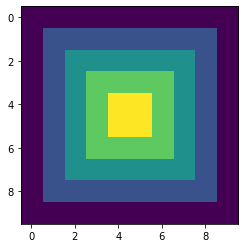

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.  ]
 [0.   0.25 0.5  0.5  0.5  0.5  0.5  0.5  0.25 0.  ]
 [0.   0.25 0.5  0.75 0.75 0.75 0.75 0.5  0.25 0.  ]
 [0.   0.25 0.5  0.75 1.   1.   0.75 0.5  0.25 0.  ]
 [0.   0.25 0.5  0.75 1.   1.   0.75 0.5  0.25 0.  ]
 [0.   0.25 0.5  0.75 0.75 0.75 0.75 0.5  0.25 0.  ]
 [0.   0.25 0.5  0.5  0.5  0.5  0.5  0.5  0.25 0.  ]
 [0.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [8]:
import numpy as np
x_shape = 10
y_shape = 10
temp = np.zeros((x_shape, y_shape))
weights_distribution = np.linspace(0, 1, x_shape // 2)
for i, l in enumerate(weights_distribution):
    temp[i:-i, i:-i] = l
plt.imshow(temp)
plt.show()
print(temp)

In [11]:
# 2D unet
"""
load past config for model training 
"""
if 'strategy' in globals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
tf.print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
if 'config_chooser' in locals():
    config_file  = config_chooser.selected
else:
    #config_file = '/mnt/data/git/cardio/reports/configs/3D/wrapper/gcn_and_acdc_exlusive_ax/2020-07-23_20_49/config.json'
    #config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax/config.json' # config for TMI paper
    #config_file = '/mnt/ssd/git/cardio/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-13_12_09/config.json' # retrained with downsampling - maybe wrong
    config_file = '/mnt/ssd/git/cardio/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/config.json' # retrained with downsampling
load = True # change to false, if this pipeline is used without finetuning
# load config with all params into global namespace
from src.models.ModelUtils import load_pretrained_model
if load: # load pretrained model
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
    #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))

    try:
        with strategy.scope():
            globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False)
            #globals()['unet'].summary()
    except Exception as e:
        logging.error(str(e))

Number of devices: 2


2020-11-27 18:21:14,535 INFO Load model from Experiment: 2D/gcn_05_2020_sax_excl_ax_patients
2020-11-27 18:21:14,535 INFO load model with keras api
2020-11-27 18:21:16,834 INFO Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.
2020-11-27 18:21:16,835 INFO Keras API failed, use json repr. load model from: models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/model.json .
2020-11-27 18:21:16,835 INFO loading model description


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-27 18:21:16,907 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-27 18:21:16,911 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-27 18:21:16,915 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-27 18:21:16,918 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-27 18:21:16,927 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-27 18:21:16,930 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-27 18:21:16,959 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-27 18:21:16,962 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-27 18:21:16,965 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2020-11-27 18:21:16,968 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2020-11-27 18:21:17,687 INFO loading model weights
2020-11-27 18:21:17,846 INFO model models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/model.json loaded


In [12]:
if 'strategy' in globals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
with strategy.scope():
    model = st.create_affine_cycle_transformer_model(config=config, metrics=metrics, unet=locals().get('unet', None))

Instructions for updating:
Use fn_output_signature instead


2020-11-27 18:21:24,312 WARNING From /home/sven/anaconda3/envs/ax2sax/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:574: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
2020-11-27 18:21:25,568 INFO unet given, use it to max probability
2020-11-27 18:21:41,981 INFO adding ax2sax MSE loss with a weighting of 1.0
2020-11-27 18:21:41,982 INFO adding cycle loss with a weighting of 1.0
2020-11-27 18:21:41,983 INFO adding focus loss on mask_prob with a weighting of 1.0


In [13]:
model.summary(line_length=150)
#plot_model(model, to_file='reports/figures/temp_graph.pdf',show_shapes=True)

Model: "affine_cycle_transformer"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 72, 112, 112, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
conv_encoder (ConvEncoder)                       ((None, 4, 7, 7, 256), [(None, 7 3537424           input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
global_average_pooling3d (GlobalAveragePooling3D (None, 256)

In [14]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),mask_smaller_than='0.001', slice_by=(1,6)):
    global m
    import numpy as np
    temp = x[im]
    sax = x2[im]
    temp_ = y[im]
    
    mask = temp_ >float(mask_smaller_than)
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on: {}'.format(temp.shape))
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, prob, ax_msk,m, m_mod = model.predict(x = [np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])                     
    logging.info('rotated by the model: {}'.format(pred[0].shape))
    show_2D_or_3D(pred[0][::slice_by], mask[::slice_by])
    plt.show()
    logging.info('inverse rotation on SAX: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    logging.info('predicted mask: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(prob[0][::slice_by])
    plt.show()
    logging.info('predicted mask in ax: {}'.format(ax_msk[0].shape))
    show_2D_or_3D(ax_msk[0][::slice_by])
    plt.show()
    
    # calculate the loss mask from target AX2SAX image
    mask = temp_ >float(mask_smaller_than)
    logging.info('masked by GT: {}'.format(mask.shape))
    masked = pred[0] * mask
    show_2D_or_3D(masked[::slice_by], mask[::slice_by])
    plt.show()
    logging.info('target (AX2SAX): {}'.format(temp_.shape))
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('Created MSE mask by thresholding the target (AX2SAX) with {}: {}'.format(mask_smaller_than,temp_.shape))
    show_2D_or_3D(mask[::slice_by])
    plt.show()
    logging.info('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
    logging.info('prob loss: {}'.format(metr.max_volume_loss(min_probabillity=0.5)(temp_[tf.newaxis,...],prob).numpy().mean()))
    try:
        print(np.reshape(m[0],(3,4)))
        print(np.reshape(m_mod[0],(3,4)))
    except Exception as e:
        pass

interactive(children=(IntSlider(value=0, description='im', max=1), Text(value='0.001', description='mask_small…

In [15]:
# train one model
initial_epoch = 0
# training

# start a new main process for this training to free gpu memory afterwards
logging.info('Fit model, start trainings process')
# fit model with trainingsgenerator
results = model.fit(
    x=batch_generator,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=200,
    callbacks = get_callbacks(config, valid_generator),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    #max_queue_size=24,
    #workers=10,
    verbose=1)

2020-11-27 18:22:29,658 INFO Fit model, start trainings process


Epoch 1/200
INFO:tensorflow:batch_all_reduce: 44 all-reduces with algorithm = nccl, num_packs = 1


2020-11-27 18:23:19,625 INFO batch_all_reduce: 44 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 44 all-reduces with algorithm = nccl, num_packs = 1


2020-11-27 18:24:07,134 INFO batch_all_reduce: 44 all-reduces with algorithm = nccl, num_packs = 1


60/60 [==============================] - ETA: 0s - loss: 3.1796 - ax2sax_loss: 1.2334 - sax2ax_loss: 0.9544 - mask_prob_loss: 0.9918
Epoch 00001: val_loss improved from inf to 3.18570, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19/model.h5
60/60 [==============================] - 147s 2s/step - loss: 3.1796 - ax2sax_loss: 1.2334 - sax2ax_loss: 0.9544 - mask_prob_loss: 0.9918 - val_loss: 3.1857 - val_ax2sax_loss: 1.1829 - val_sax2ax_loss: 1.0122 - val_mask_prob_loss: 0.9906 - lr: 1.0000e-04
Epoch 2/200
60/60 [==============================] - ETA: 0s - loss: 3.1357 - ax2sax_loss: 1.2060 - sax2ax_loss: 0.9374 - mask_prob_loss: 0.9923
Epoch 00002: val_loss improved from 3.18570 to 3.16641, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19/model.h5
60/60 [==============================] - 112s 2s/step - loss: 3.1357 - ax2sax_loss: 1.2060 - sax2ax_loss: 0.9374 - mask_prob_loss: 0.9923 - val_loss: 3.1664 

In [ ]:
#tf.keras.models.save_model(model,filepath=config['MODEL_PATH'],overwrite=True,include_optimizer=False,save_format='tf')

In [ ]:
config['MODEL_PATH']

In [16]:
# load pre-trained AXtoSAX rotation model

"""
load past config for model training 
"""
if 'strategy' in locals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
#config_file  = 'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_08_29/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_10_30/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_11_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_13_34/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-25_11_04/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_10_24/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_14_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_16_27/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_20_53/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_22_26/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_08_08/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_09_23/config.json'

# Full 4folds
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-04_14_04/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_16_45/config.json' # fold0, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_23_22/config.json' # fold2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-05_08_42/config.json' # fold1, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-05_17_52/config.json' # fold3 2nd, guter Fold

# baseline_cycle fold 0 - did not converge in most of the folds
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_21_30/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_22_22/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_23_06/config.json'

# baseline_cycle
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_08_29/config.json' # fold0
# baseline_cycle Fold 1 did not converge, with this modification it learnt very well:  with 96 x 224 x 224 and inplane weighting
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_12_48/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_14_54/config.json' # fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_16_17/config.json' # fold 3

# full model with inplane
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_00_31/config.json' # fold 0
# fold 1 repeat, looks good 3D/ax_sax/full/baseline_cycle_unet/2020-08-07_16_42/
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_07_51/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_11_42/config.json' # fold 3, did not work
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_18_28/config.json' # fold 3
# on downsampled images
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-08_07_37/config.json' Fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_16_20/config.json' Fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_21_15/config.json' Fold 1

# baseline_unet
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_10_20/config.json' # fold 0
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_11_34/config.json' # fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_15_23/config.json' fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_13_02/config.json' # fold 3

# full model, with inplane and 128
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_16_24/config.json' # fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_18_38/config.json' #fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_11_53/config.json' # fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_12_57/config.json'# fold3

# temp
#config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_1_unet/2020-09-30_18_31/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_1_ax_1_sax_1_unet/2020-10-01_10_13/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_2_ax_2_sax_1_mask2ax_unet/2020-10-01_15_05/config.json'
# config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_2_mask2ax_unet/2020-10-01_16_17/config.json'

# Repeat full model on all folds with: weighting mask 1, ax 2, sax 2 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_2_sax_2_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax 1_ax_2_sax_2_full/2020-10-13_17_57/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_09_32/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_11_24/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_16_02/config.json' # Fold 3


# Repeat full model on all folds with: weighting mask 1, ax 10, sax 10 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_10_sax_10_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-14_23_10/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_08_48/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_10_44/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_09_45/config.json' # Fold 3

#Use the SAX probability for the focus_loss instead of the SAX2AX probability
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_10_37/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_12_37/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_13_15/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_15_27/config.json' # Fold 3


# Basline model with AX MSE as loss and inplane weighting
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_14_50/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_16_39/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_09_42/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_10_37/config.json' # Fold 3

# Basline model with inplane and bool loss switches
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold0/2020-10-19_14_47/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold1/2020-10-19_15_18/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold2/2020-10-19_18_14/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold3/2020-10-19_18_49/config.json' # Fold 3 # did not converge, which is ok and a problem of the baseline

# Baseline model without inplane and bool loss switches
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold0/2020-10-20_08_55/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold1/2020-10-20_09_20/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold2/2020-10-20_09_49/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold3/2020-10-20_10_16/config.json' # Fold 3

# Baseline model with inplane and focus loss on sax masks
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold0/2020-10-20_12_04/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold1/2020-10-20_13_17/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold2/2020-10-20_13_44/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold3/2020-10-20_15_32/config.json' # Fold 3


# new cropping = no square cropping before resampling and crop or pad
# --> 'data/predicted/papernewcrop_baseline_1ax_1sax_01focus_inplane/3D/'
# Baseline model with inplane 1cycle and 0.1focus loss on sax masks 
#/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold1/2020-10-21_17_31/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold2/2020-10-21_19_04/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold3/2020-10-21_22_48/config.json' # Fold 3 # new cropping


# Baseline model with inplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold0/2020-10-22_07_41/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold1/2020-10-22_08_15/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold2/2020-10-22_09_54/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold3/2020-10-22_10_16/config.json' # Fold 3 # new cropping

# Baseline model with NOinplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-22_12_07/config.json' # Fold 0 # new cropping

# trained on spacing of 3, did not perform better than the full pipeline
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold0/2020-10-22_12_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold1/2020-10-22_19_50/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold2/2020-10-22_22_03/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold3/2020-10-23_07_35/config.json' # Fold 4


# Baseline model ax1 sax0 focus0 NoInplane, experiment name is wrong! this experiments are with AX MSE and no inplane!
#config_file = 'reports/configs/3D/ax_sax/paper/aseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-26_12_07/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-26_12_56/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-26_13_53/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-26_16_03/config.json' # Fold 3 


# baseline ax1 sax0 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold0/2020-10-27_08_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold1/2020-10-27_10_53/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold2/2020-10-27_11_39/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold3/2020-10-27_12_48/config.json' # Fold 3



# baseline ax1 sax1 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-27_15_09/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-27_16_11/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-27_17_02/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-27_18_11/config.json' # Fold 2 


# baseline ax1 sax1 focus0 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-27_19_31/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold1/2020-10-27_22_17/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold2/2020-10-27_22_37/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold3/2020-10-27_22_55/config.json' # Fold 3

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling 64,112,112
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-16_16_30/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_16_51/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_18_34/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,56,56 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_19_37/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_09_52/config.json' # Fold 0

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_12_45/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_14_33/config.json' # Fold 2

# center cropping and size of 64 64 64 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_16_13/config.json' # Fold 2

# center cropping and size of 64 112 112 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_17_08/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 WITH inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_18_31/config.json' # Fold 2

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_22_00/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_09_20/config.json' # Fold 0

# baseline ax1 sax1 focus1 inplane - unet with downsampling - 72,112,112 spacing 3,3,3  inplx100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_11_00/config.json' # Fold 0

# baseline ax1 sax1 focus1 on_SAXpred  NOinplane - unet with downsampling - 72,112,112 spacing 3,3,3  inplx100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_12_36/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_12_36/config.json' # Fold 0

config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19/config.json' # Fold 0




# load model via tf.keras.load_model (full), if not possible try with json and weights
from src.models.ModelUtils import load_pretrained_model
if True: # load pretrained model switch to run all cells
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

    try:
        with strategy.scope():
            globals()['model'] = load_pretrained_model(config_temp, metrics, comp=False)
            #model.summary()
    except Exception as e:
        # create a new model and try to load the weights
        logging.error(str(e))
        with strategy.scope():
            globals()['model'] = st.create_affine_cycle_transformer_model(config=config_temp, metrics=metrics, unet=locals().get('unet', None))
            model.load_weights(os.path.join(config_temp['MODEL_PATH'],'model.h5'))
            logging.info('loaded model weights as h5 file')

2020-11-27 19:53:01,123 INFO Load model from Experiment: 3D/ax_sax/unetwithdownsamplingaugmentation_new_data
2020-11-27 19:53:01,124 INFO load model with keras api
2020-11-27 19:53:01,125 INFO SavedModel file does not exist at: models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19/{saved_model.pbtxt|saved_model.pb}
2020-11-27 19:53:01,125 INFO Keras API failed, use json repr. load model from: models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19/model.json .
2020-11-27 19:53:01,126 ERROR [Errno 2] No such file or directory: 'models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19/model.json'
2020-11-27 19:53:01,896 INFO unet given, use it to max probability
2020-11-27 19:53:18,662 INFO adding ax2sax MSE loss with a weighting of 1.0
2020-11-27 19:53:18,663 INFO adding cycle loss with a weighting of 1.0
2020-11-27 19:53:18,664 INFO adding focus loss on mask_prob with a weighting of 1.0
2020-11-27 19:53:18,960 INFO loaded mod

# Fast predictions with all files of the generator

In [17]:
from src.utils.Metrics_own import loss_with_margin as cube_loss
import numpy as np
cfg = config.copy()
cfg['BATCHSIZE'] = 10
cfg['AUGMENT_GRID'] = False
valid_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, cfg)
input_, output_ = valid_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, pred_mask, ax2sax_msk,m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])

    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation of the model')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask:')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    #print('MSE: {}'.format(mse(temp_, pred[0]).numpy().mean()))
    #print('max volume loss: {}'.format(metr.max_volume_loss(min_probabillity=0.8,z_weight=True)(temp[None,...], pred_mask).shape))
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-11-27 19:53:18,984 INFO Create DataGenerator
2020-11-27 19:53:18,985 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 10
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 2
2020-11-27 19:53:18,985 INFO No augmentation


interactive(children=(IntSlider(value=4, description='im', max=9), IntSlider(value=3, description='slice_by', …

# Predictions on the heldout test split

In [12]:
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    
    pred, inv_pred, ax2sax_mod, pred_mask, ax_mask, m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])
    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('predicted in AX')
    show_2D_or_3D(ax_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    print('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
    #print('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-10-29 17:17:51,779 INFO Create DataGenerator
2020-10-29 17:17:51,780 INFO Datagenerator created with: 
 shape: [32, 64, 64]
 spacing: [5, 5, 5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 32
2020-10-29 17:17:51,780 INFO No augmentation


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=3, description='slice_by'…

## 1. AX and SAX volumes 

Create a MotionDatagenerator from the heldout test split without shuffle and batchsize == len(files)

## 2. AX images and AX masks

Create a Datagenerator from AX image and mask files, both will be used in the next cell for the prediction pipeline

In [43]:
# Load a second unet, this could be used to combine the predictions
if False:
    from src.models.KerasLayers import UnetWrapper
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input
    config_file2 = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax/config.json' # config for TMI paper

    with open(config_file2, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
    #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
    try:
        with strategy.scope():
            globals()['unet2'] = load_pretrained_model(config_temp, metrics, comp=False)
            #globals()['unet'].summary()
    except Exception as e:
        logging.error(str(e))
        
    inp = Input((144, 224, 224, 1)) # one 3d volume in full resolution
    out = UnetWrapper(unet=unet2, resize=True)(inp)
    unet_model2 = Model(inputs=[inp], outputs=[out])

2020-11-20 16:12:27,325 INFO Load model from Experiment: 2D/ax_sax/gcn_and_acdc_exlusive_ax/
2020-11-20 16:12:27,328 INFO load model with keras api
2020-11-20 16:12:29,438 INFO Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.
2020-11-20 16:12:29,438 INFO Keras API failed, use json repr. load model from: models/2D/gcn_and_acdc_excl_ax/model.json .
2020-11-20 16:12:29,453 INFO loading model description
2020-11-20 16:12:30,299 INFO loading model weights
2020-11-20 16:12:30,500 INFO model models/2D/gcn_and_acdc_excl_ax/model.json loaded


In [18]:
# create a motion generator from the val files without shuffle for sorted predictions
from src.models.SpatialTransformer import create_affine_transformer_fixed
from src.data.Preprocess import from_channel_to_flat, transform_to_binary_mask
from src.data.Postprocess import clean_3d_prediction_3d_cc
import shutil
from src.data.Dataset import copy_meta_and_save
# unetwrapper
from src.models.KerasLayers import UnetWrapper
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
cfg['SHUFFLE'] = False
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
msk_cfg = cfg.copy()
msk_cfg['IMG_CHANNELS'] = 1
msk_cfg['DIM'] = [144,224,224]
msk_cfg['SPACING'] = [1.5,1.5,1.5]
msk_cfg['RESAMPLE'] = True
v_msk_generator = DataGenerator(x_val_ax, y_val_ax, msk_cfg)
ax_full, ax_msk_ = v_msk_generator.__getitem__(0)


inp = Input((144, 224, 224, 1)) # one 3d volume in full resolution
out = UnetWrapper(unet=unet, resize=False)(inp)
unet_model = Model(inputs=[inp], outputs=[out])


2020-11-27 19:54:00,740 INFO Create DataGenerator
2020-11-27 19:54:00,741 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-11-27 19:54:00,741 INFO No augmentation
2020-11-27 19:54:02,265 INFO Create DataGenerator
2020-11-27 19:54:02,266 INFO Datagenerator created with: 
 shape: [144, 224, 224]
 spacing: [1.5, 1.5, 1.5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-11-27 19:54:02,267 INFO No augmentation


## Predict AXtoSAX rotation, predict SAX Segmentation, rotate the mask reverse (SAXtoAX) by the predicted inverse
Complete pipeline:
1. AX_isotrop, 
2. Motion-generator which center crops or resize (needs to be changed) in plane, crop and pad in Z  to align to the network shape, no further resampling
3. Rotated into SAX domain by the trained Spatial-Transformer + Encoder (trained on the trainings split)
4. Mask prediction with a 3D Wrapper, fed with a pre-trained 2D unet (traind on fold1 from the improved SPIE pipeline)
5. Connected Component filtering & binarizing with a threshold of 0.5
6. Label-wise transformation of the mask back into the AX domain (with linear interpolation) inverted matrix from 3.
7. Second Connected Component Filtering (need to be checked if really necessary)
8. Copied the dicom metadata, direction and origin from the original AX_isotrop file to the predicted mask, the input AX image, and the AX GT mask, saved all three files
9. Evaluated 3D metrics on the Pred and GT 3D Masks, both files have a spacing of (1.5,1.5,1.5) and a size of 80,224,224 (better would be to use the AX_isotrop mask before the generator, therefore the generator steps need to be inverted, in some very few cases we resize here which is an nearest neighbor interpolation on the GT mask. This step could be changed to padding, but was kept to resize to align with the trainings preprocessing of the unet)

In [19]:
#### 1st try to reconstruct the original physical size
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to enable plotting of the intermediate steps
    :param postprocess: bool to enable plotting of the intermediate steps
    :param use_mod: bool to enable plotting of the intermediate steps
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to predict with two models on the ax2sax volues
    :return: void
    """
    global m
    from src.data.Preprocess import normalise_image
    tf.get_logger().setLevel('ERROR')
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()
    
    # TODO: change m and m_ if we modify the translation parameters
    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n])
    plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    ax2sax_full = normalise_image(ax2sax_full)
    
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    # second prediction on the transformed SAX image with a second unet
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,-3:] = msk[...,-3:] + msk2[...,-3:]
    
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    logging.getLogger().setLevel(logging.ERROR)
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channels in the unet - without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        inv_msk = (inv_msk + msk_ax) >=0.9
        logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        # maybe use a bigger kernel to close missed slices
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    # create a nrrd file for the gt, pred and image volume
    sitk_pred = sitk.GetImageFromArray(inv_msk)
    sitk_ax_img = sitk.GetImageFromArray(ax_full_)
    sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    # load a reference nrrd file, copy all metadata and save the volumes
    reference_sitk = sitk.ReadImage(full_file_name)
    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))

    logging.info('inv mask shape: {}, gt mask shape: {}'.format(transform_to_binary_mask(inv_msk).shape, ax_msk_full_gt.shape))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# This version was used for the TMI paper !!!

In [30]:
#### NEW VERSIoN WITH full resolution ####
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to enable plotting of the intermediate steps
    :param postprocess: bool to enable plotting of the intermediate steps
    :param use_mod: bool to enable plotting of the intermediate steps
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to predict with two models on the ax2sax volues
    :return: void
    """
    global m
    from src.data.Preprocess import normalise_image
    tf.get_logger().setLevel('ERROR')
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()
    
    # TODO: change m and m_ if we modify the translation parameters
    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n])
    plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    ax2sax_full = normalise_image(ax2sax_full)
    
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    # second prediction on the transformed SAX image with a second unet
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,-3:] = msk[...,-3:] + msk2[...,-3:]
    
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    logging.getLogger().setLevel(logging.ERROR)
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channels in the unet - without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        inv_msk = (inv_msk + msk_ax) >=0.9
        logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        # maybe use a bigger kernel to close missed slices
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    # create a nrrd file for the gt, pred and image volume
    sitk_pred = sitk.GetImageFromArray(inv_msk)
    sitk_ax_img = sitk.GetImageFromArray(ax_full_)
    sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    # load a reference nrrd file, copy all metadata and save the volumes
    reference_sitk = sitk.ReadImage(full_file_name)
    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))

    logging.info('inv mask shape: {}, gt mask shape: {}'.format(transform_to_binary_mask(inv_msk).shape, ax_msk_full_gt.shape))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# Make multiple predictions and save the predicted mask, the gt mask and the image to a given experiment identifier for further evaluation and comparison

2020-11-27 19:58:54,439 INFO use modified translation to scale: True
2020-11-27 19:58:54,440 INFO 0000-0HQQW4ZN_2007-05-23_ED_msk.nrrd
2020-11-27 19:58:54,440 INFO Prediction on AX volume:
2020-11-27 19:58:55,154 INFO AX --> SAX rotated by the model
2020-11-27 19:58:55,156 INFO AX --> SAX with modified m rotated by the model
2020-11-27 19:58:55,197 INFO Target (AX2SAX):
2020-11-27 19:58:55,198 INFO Repeat the transformation on the full resolution
2020-11-27 19:58:57,841 INFO Predicted mask
2020-11-27 19:58:59,487 INFO Predicted mask rotated to AX on original AX image - before postprocessing
2020-11-27 19:58:59,600 INFO DICE LV: 0.84726881980896
2020-11-27 19:58:59,673 INFO DICE RV: 0.8595758676528931
2020-11-27 19:58:59,748 INFO DICE MYO: 0.5836074352264404
2020-11-27 19:58:59,754 INFO Predicted mask rotated to AX on original AX image - after closing
2020-11-27 19:58:59,759 INFO Predicted mask rotated to AX on original AX image - after opening
2020-11-27 19:59:00,231 INFO Predicted mas

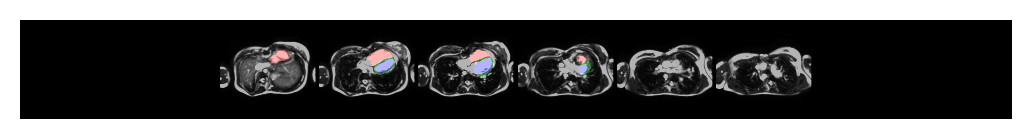

2020-11-27 19:59:00,627 INFO GT on AX


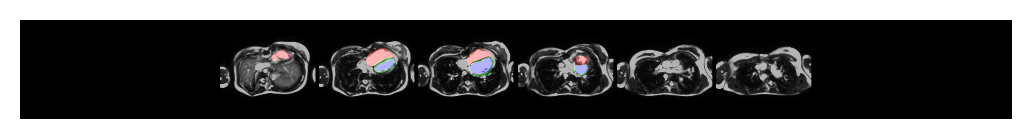

2020-11-27 19:59:01,049 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 19:59:01,123 INFO DICE LV: 0.8765178322792053
2020-11-27 19:59:01,196 INFO DICE RV: 0.8616064786911011
2020-11-27 19:59:01,270 INFO DICE MYO: 0.5956584811210632
2020-11-27 19:59:01,322 INFO m: [[ 0.4636 -0.821  -0.334  -0.999 ]
 [ 0.3503 -0.1766  0.92   -0.9966]
 [-0.814  -0.5435  0.2057 15.66  ]]
2020-11-27 19:59:01,323 INFO m_mod: [[ 0.4636 -0.821  -0.334  -0.4775]
 [ 0.3503 -0.1766  0.92    0.9204]
 [-0.814  -0.5435  0.2057  1.295 ]]
2020-11-27 19:59:01,323 INFO m_scaled: [[ 0.4636 -0.821  -0.334  -0.955 ]
 [ 0.3503 -0.1766  0.92    1.841 ]
 [-0.814  -0.5435  0.2057  2.59  ]]
2020-11-27 19:59:01,324 INFO 0000-0HQQW4ZN_2007-05-23_ES_msk.nrrd
2020-11-27 19:59:01,324 INFO Prediction on AX volume:
2020-11-27 19:59:01,994 INFO AX --> SAX rotated by the model
2020-11-27 19:59:01,995 INFO AX --> SAX with modified m rotated by the model
2020-11-27 19:59:02,021 INFO Target (AX2SAX):


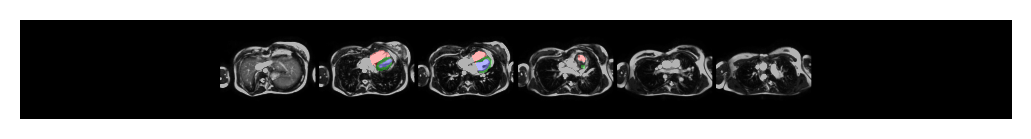

2020-11-27 19:59:07,375 INFO GT on AX


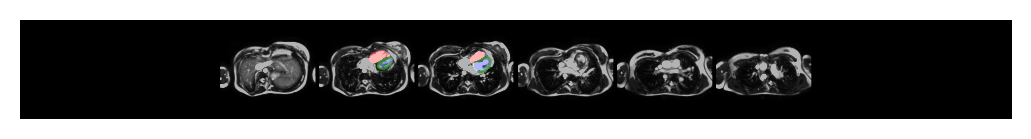

2020-11-27 19:59:07,798 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 19:59:07,876 INFO DICE LV: 0.8362817764282227
2020-11-27 19:59:07,950 INFO DICE RV: 0.8250653147697449
2020-11-27 19:59:08,024 INFO DICE MYO: 0.6824218034744263
2020-11-27 19:59:08,065 INFO m: [[ 0.4658 -0.824  -0.3208 -0.999 ]
 [ 0.3496 -0.1614  0.923  -0.9966]
 [-0.8125 -0.542   0.213  15.49  ]]
2020-11-27 19:59:08,066 INFO m_mod: [[ 0.4658 -0.824  -0.3208 -0.4736]
 [ 0.3496 -0.1614  0.923   0.9106]
 [-0.8125 -0.542   0.213   1.281 ]]
2020-11-27 19:59:08,066 INFO m_scaled: [[ 0.4658 -0.824  -0.3208 -0.9473]
 [ 0.3496 -0.1614  0.923   1.821 ]
 [-0.8125 -0.542   0.213   2.562 ]]
2020-11-27 19:59:08,067 INFO 0000-13JLP3HN_2007-05-22_ED_msk.nrrd
2020-11-27 19:59:08,067 INFO Prediction on AX volume:
2020-11-27 19:59:08,736 INFO AX --> SAX rotated by the model
2020-11-27 19:59:08,736 INFO AX --> SAX with modified m rotated by the model
2020-11-27 19:59:08,758 INFO Target (AX2SAX):


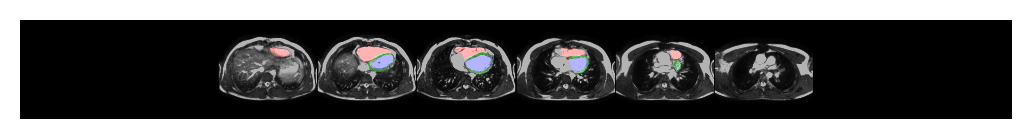

2020-11-27 19:59:15,180 INFO GT on AX


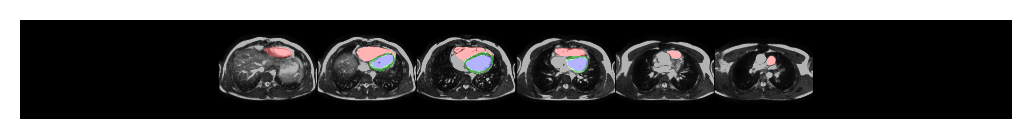

2020-11-27 19:59:15,588 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 19:59:15,676 INFO DICE LV: 0.927227795124054
2020-11-27 19:59:15,756 INFO DICE RV: 0.845308780670166
2020-11-27 19:59:15,839 INFO DICE MYO: 0.7288240790367126
2020-11-27 19:59:15,893 INFO m: [[ 0.4636 -0.821  -0.334  -0.999 ]
 [ 0.3503 -0.1766  0.92   -0.9966]
 [-0.814  -0.5435  0.2057 15.67  ]]
2020-11-27 19:59:15,894 INFO m_mod: [[ 0.4636 -0.821  -0.334  -0.4775]
 [ 0.3503 -0.1766  0.92    0.921 ]
 [-0.814  -0.5435  0.2057  1.296 ]]
2020-11-27 19:59:15,894 INFO m_scaled: [[ 0.4636 -0.821  -0.334  -0.955 ]
 [ 0.3503 -0.1766  0.92    1.842 ]
 [-0.814  -0.5435  0.2057  2.592 ]]
2020-11-27 19:59:15,895 INFO 0000-13JLP3HN_2007-05-22_ES_msk.nrrd
2020-11-27 19:59:15,895 INFO Prediction on AX volume:
2020-11-27 19:59:16,572 INFO AX --> SAX rotated by the model
2020-11-27 19:59:16,574 INFO AX --> SAX with modified m rotated by the model
2020-11-27 19:59:16,621 INFO Target (AX2SAX):
20

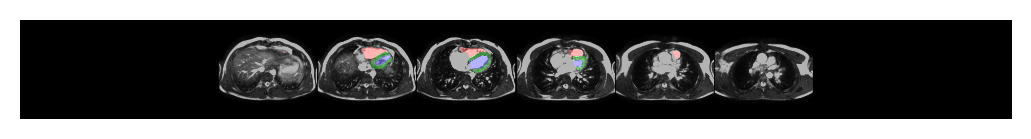

2020-11-27 19:59:21,962 INFO GT on AX


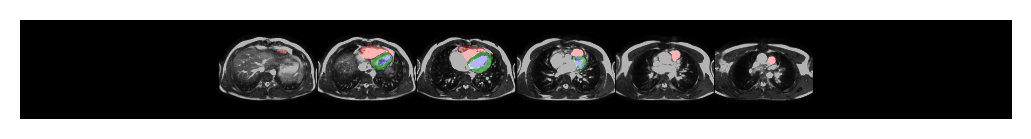

2020-11-27 19:59:22,374 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 19:59:22,455 INFO DICE LV: 0.8617933392524719
2020-11-27 19:59:22,535 INFO DICE RV: 0.7418633699417114
2020-11-27 19:59:22,615 INFO DICE MYO: 0.7427082657814026
2020-11-27 19:59:22,670 INFO m: [[ 0.467  -0.827  -0.3135 -0.999 ]
 [ 0.349  -0.1534  0.925  -0.9966]
 [-0.8125 -0.541   0.2169 15.414 ]]
2020-11-27 19:59:22,670 INFO m_mod: [[ 0.467  -0.827  -0.3135 -0.4722]
 [ 0.349  -0.1534  0.925   0.9062]
 [-0.8125 -0.541   0.2169  1.275 ]]
2020-11-27 19:59:22,671 INFO m_scaled: [[ 0.467  -0.827  -0.3135 -0.9443]
 [ 0.349  -0.1534  0.925   1.8125]
 [-0.8125 -0.541   0.2169  2.55  ]]
2020-11-27 19:59:22,671 INFO 0000-24YLF77L_2007-11-19_ED_msk.nrrd
2020-11-27 19:59:22,671 INFO Prediction on AX volume:
2020-11-27 19:59:23,345 INFO AX --> SAX rotated by the model
2020-11-27 19:59:23,345 INFO AX --> SAX with modified m rotated by the model
2020-11-27 19:59:23,365 INFO Target (AX2SAX):


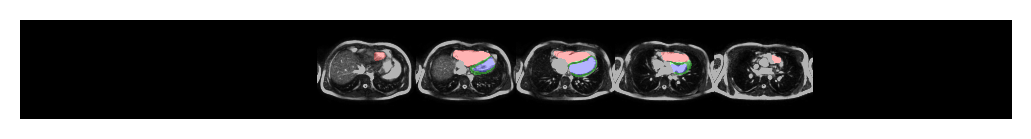

2020-11-27 19:59:28,625 INFO GT on AX


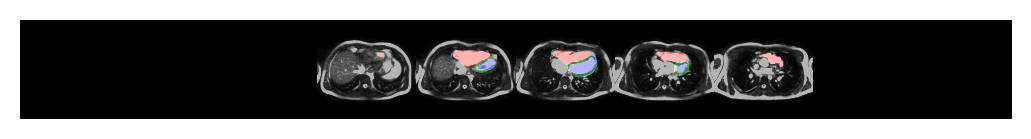

2020-11-27 19:59:29,040 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 19:59:29,129 INFO DICE LV: 0.901987612247467
2020-11-27 19:59:29,210 INFO DICE RV: 0.8754684329032898
2020-11-27 19:59:29,290 INFO DICE MYO: 0.6758512258529663
2020-11-27 19:59:29,345 INFO m: [[ 0.4714 -0.8325 -0.2905 -0.999 ]
 [ 0.347  -0.1273  0.9287 -0.996 ]
 [-0.8105 -0.539   0.229  15.14  ]]
2020-11-27 19:59:29,346 INFO m_mod: [[ 0.4714 -0.8325 -0.2905 -0.4658]
 [ 0.347  -0.1273  0.9287  0.89  ]
 [-0.8105 -0.539   0.229   1.252 ]]
2020-11-27 19:59:29,346 INFO m_scaled: [[ 0.4714 -0.8325 -0.2905 -0.9316]
 [ 0.347  -0.1273  0.9287  1.78  ]
 [-0.8105 -0.539   0.229   2.504 ]]
2020-11-27 19:59:29,347 INFO 0000-24YLF77L_2007-11-19_ES_msk.nrrd
2020-11-27 19:59:29,347 INFO Prediction on AX volume:
2020-11-27 19:59:30,018 INFO AX --> SAX rotated by the model
2020-11-27 19:59:30,018 INFO AX --> SAX with modified m rotated by the model
2020-11-27 19:59:30,038 INFO Target (AX2SAX):
2

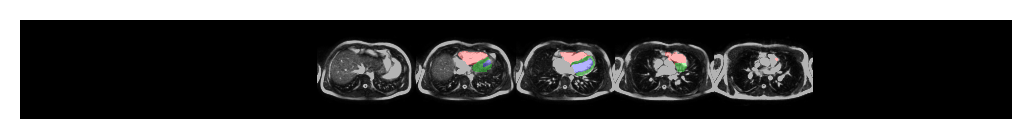

2020-11-27 19:59:35,291 INFO GT on AX


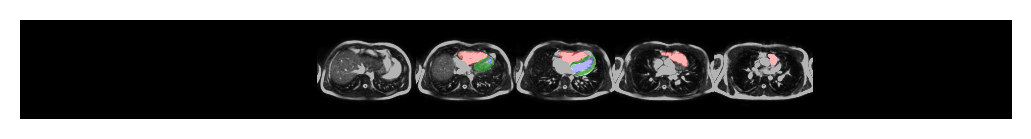

2020-11-27 19:59:35,690 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 19:59:35,777 INFO DICE LV: 0.8449349999427795
2020-11-27 19:59:35,863 INFO DICE RV: 0.8495801091194153
2020-11-27 19:59:35,941 INFO DICE MYO: 0.7427147626876831
2020-11-27 19:59:35,994 INFO m: [[ 0.4707 -0.832  -0.2937 -0.999 ]
 [ 0.3474 -0.131   0.928  -0.996 ]
 [-0.811  -0.539   0.2272 15.18  ]]
2020-11-27 19:59:35,995 INFO m_mod: [[ 0.4707 -0.832  -0.2937 -0.4668]
 [ 0.3474 -0.131   0.928   0.892 ]
 [-0.811  -0.539   0.2272  1.255 ]]
2020-11-27 19:59:35,996 INFO m_scaled: [[ 0.4707 -0.832  -0.2937 -0.9336]
 [ 0.3474 -0.131   0.928   1.784 ]
 [-0.811  -0.539   0.2272  2.51  ]]
2020-11-27 19:59:35,996 INFO 0000-2CVUG1C5_2006-09-06_ED_msk.nrrd
2020-11-27 19:59:35,997 INFO Prediction on AX volume:
2020-11-27 19:59:36,681 INFO AX --> SAX rotated by the model
2020-11-27 19:59:36,683 INFO AX --> SAX with modified m rotated by the model
2020-11-27 19:59:36,737 INFO Target (AX2SAX):


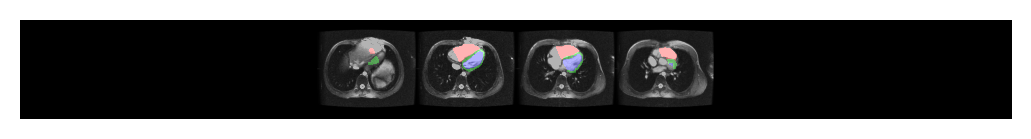

2020-11-27 19:59:42,015 INFO GT on AX


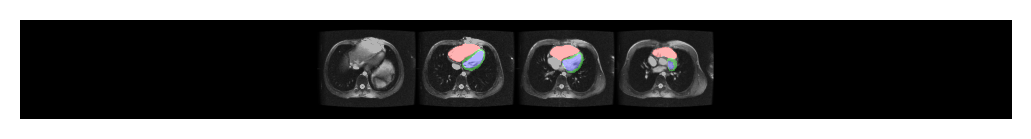

2020-11-27 19:59:42,420 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 19:59:42,507 INFO DICE LV: 0.8672942519187927
2020-11-27 19:59:42,593 INFO DICE RV: 0.7912083268165588
2020-11-27 19:59:42,674 INFO DICE MYO: 0.641400933265686
2020-11-27 19:59:42,729 INFO m: [[ 0.4636 -0.821  -0.335  -0.999 ]
 [ 0.3503 -0.1777  0.92   -0.9966]
 [-0.814  -0.5435  0.2051 15.67  ]]
2020-11-27 19:59:42,730 INFO m_mod: [[ 0.4636 -0.821  -0.335  -0.4775]
 [ 0.3503 -0.1777  0.92    0.921 ]
 [-0.814  -0.5435  0.2051  1.296 ]]
2020-11-27 19:59:42,730 INFO m_scaled: [[ 0.4636 -0.821  -0.335  -0.955 ]
 [ 0.3503 -0.1777  0.92    1.842 ]
 [-0.814  -0.5435  0.2051  2.592 ]]
2020-11-27 19:59:42,731 INFO 0000-2CVUG1C5_2006-09-06_ES_msk.nrrd
2020-11-27 19:59:42,732 INFO Prediction on AX volume:
2020-11-27 19:59:43,413 INFO AX --> SAX rotated by the model
2020-11-27 19:59:43,416 INFO AX --> SAX with modified m rotated by the model
2020-11-27 19:59:43,470 INFO Target (AX2SAX):
2

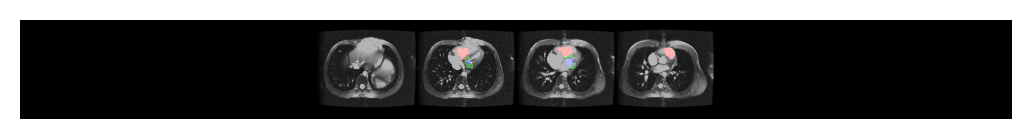

2020-11-27 19:59:48,761 INFO GT on AX


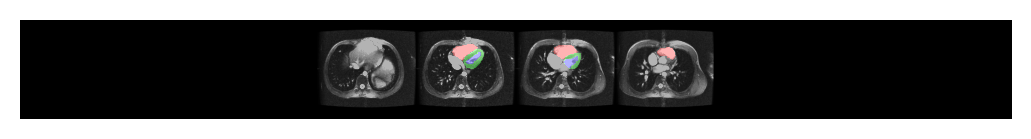

2020-11-27 19:59:49,173 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 19:59:49,260 INFO DICE LV: 0.5828959941864014
2020-11-27 19:59:49,339 INFO DICE RV: 0.5681652426719666
2020-11-27 19:59:49,417 INFO DICE MYO: 0.36825716495513916
2020-11-27 19:59:49,471 INFO m: [[ 0.4648 -0.8223 -0.3286 -0.999 ]
 [ 0.35   -0.1703  0.9214 -0.9966]
 [-0.8135 -0.5435  0.2087 15.586 ]]
2020-11-27 19:59:49,472 INFO m_mod: [[ 0.4648 -0.8223 -0.3286 -0.476 ]
 [ 0.35   -0.1703  0.9214  0.9165]
 [-0.8135 -0.5435  0.2087  1.289 ]]
2020-11-27 19:59:49,472 INFO m_scaled: [[ 0.4648 -0.8223 -0.3286 -0.952 ]
 [ 0.35   -0.1703  0.9214  1.833 ]
 [-0.8135 -0.5435  0.2087  2.578 ]]
2020-11-27 19:59:49,474 INFO 0000-2CW0G1A5_2006-04-06_ED_msk.nrrd
2020-11-27 19:59:49,474 INFO Prediction on AX volume:
2020-11-27 19:59:50,156 INFO AX --> SAX rotated by the model
2020-11-27 19:59:50,158 INFO AX --> SAX with modified m rotated by the model
2020-11-27 19:59:50,202 INFO Target (AX2SAX):

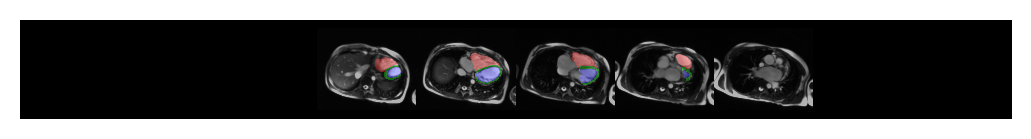

2020-11-27 19:59:55,411 INFO GT on AX


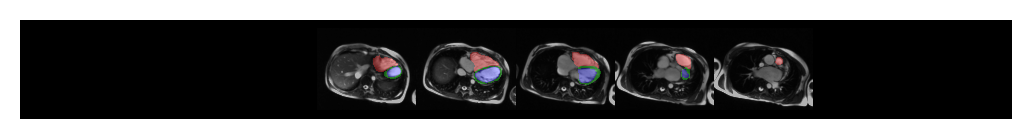

2020-11-27 19:59:55,813 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 19:59:55,892 INFO DICE LV: 0.9207009077072144
2020-11-27 19:59:55,971 INFO DICE RV: 0.8949369192123413
2020-11-27 19:59:56,050 INFO DICE MYO: 0.668857753276825
2020-11-27 19:59:56,103 INFO m: [[ 0.4617 -0.817  -0.3464 -0.999 ]
 [ 0.3513 -0.1903  0.917  -0.997 ]
 [-0.8145 -0.545   0.199  15.81  ]]
2020-11-27 19:59:56,103 INFO m_mod: [[ 0.4617 -0.817  -0.3464 -0.4805]
 [ 0.3513 -0.1903  0.917   0.929 ]
 [-0.8145 -0.545   0.199   1.308 ]]
2020-11-27 19:59:56,104 INFO m_scaled: [[ 0.4617 -0.817  -0.3464 -0.961 ]
 [ 0.3513 -0.1903  0.917   1.858 ]
 [-0.8145 -0.545   0.199   2.615 ]]
2020-11-27 19:59:56,105 INFO 0000-2CW0G1A5_2006-04-06_ES_msk.nrrd
2020-11-27 19:59:56,105 INFO Prediction on AX volume:
2020-11-27 19:59:56,782 INFO AX --> SAX rotated by the model
2020-11-27 19:59:56,783 INFO AX --> SAX with modified m rotated by the model
2020-11-27 19:59:56,815 INFO Target (AX2SAX):
2

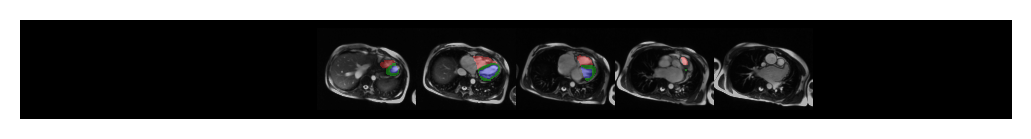

2020-11-27 20:00:02,032 INFO GT on AX


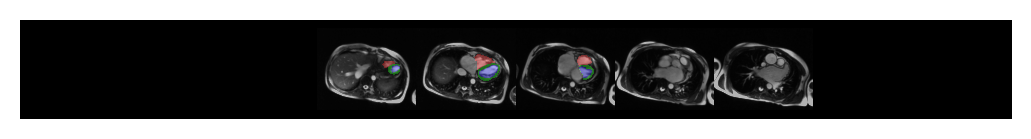

2020-11-27 20:00:02,439 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:00:02,520 INFO DICE LV: 0.8646175861358643
2020-11-27 20:00:02,598 INFO DICE RV: 0.8194411993026733
2020-11-27 20:00:02,676 INFO DICE MYO: 0.7012436985969543
2020-11-27 20:00:02,730 INFO m: [[ 0.4626 -0.819  -0.3384 -0.999 ]
 [ 0.3506 -0.1812  0.9185 -0.997 ]
 [-0.814  -0.544   0.2034 15.7   ]]
2020-11-27 20:00:02,730 INFO m_mod: [[ 0.4626 -0.819  -0.3384 -0.4785]
 [ 0.3506 -0.1812  0.9185  0.9233]
 [-0.814  -0.544   0.2034  1.299 ]]
2020-11-27 20:00:02,731 INFO m_scaled: [[ 0.4626 -0.819  -0.3384 -0.957 ]
 [ 0.3506 -0.1812  0.9185  1.847 ]
 [-0.814  -0.544   0.2034  2.598 ]]
2020-11-27 20:00:02,731 INFO 0000-2XRR719Z_2005-05-02_ED_msk.nrrd
2020-11-27 20:00:02,732 INFO Prediction on AX volume:
2020-11-27 20:00:03,408 INFO AX --> SAX rotated by the model
2020-11-27 20:00:03,409 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:00:03,429 INFO Target (AX2SAX):


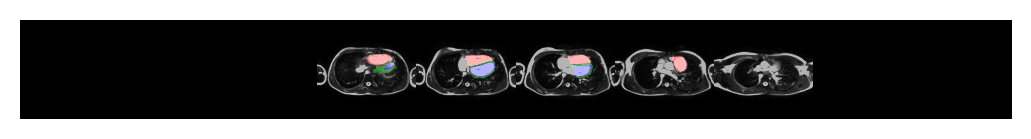

2020-11-27 20:00:08,643 INFO GT on AX


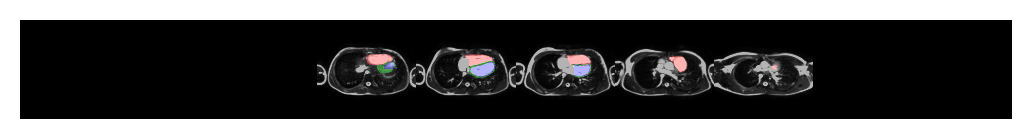

2020-11-27 20:00:09,048 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:00:09,129 INFO DICE LV: 0.922786295413971
2020-11-27 20:00:09,208 INFO DICE RV: 0.8840961456298828
2020-11-27 20:00:09,288 INFO DICE MYO: 0.6503540277481079
2020-11-27 20:00:09,342 INFO m: [[ 0.4727 -0.834  -0.2842 -0.999 ]
 [ 0.347  -0.1205  0.93   -0.996 ]
 [-0.81   -0.538   0.2325 15.06  ]]
2020-11-27 20:00:09,342 INFO m_mod: [[ 0.4727 -0.834  -0.2842 -0.4644]
 [ 0.347  -0.1205  0.93    0.8853]
 [-0.81   -0.538   0.2325  1.245 ]]
2020-11-27 20:00:09,343 INFO m_scaled: [[ 0.4727 -0.834  -0.2842 -0.9287]
 [ 0.347  -0.1205  0.93    1.7705]
 [-0.81   -0.538   0.2325  2.49  ]]
2020-11-27 20:00:09,344 INFO 0000-2XRR719Z_2005-05-02_ES_msk.nrrd
2020-11-27 20:00:09,344 INFO Prediction on AX volume:
2020-11-27 20:00:10,028 INFO AX --> SAX rotated by the model
2020-11-27 20:00:10,029 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:00:10,067 INFO Target (AX2SAX):
2

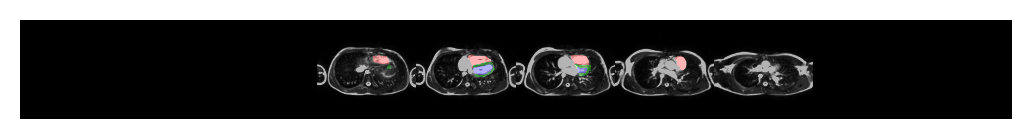

2020-11-27 20:00:15,282 INFO GT on AX


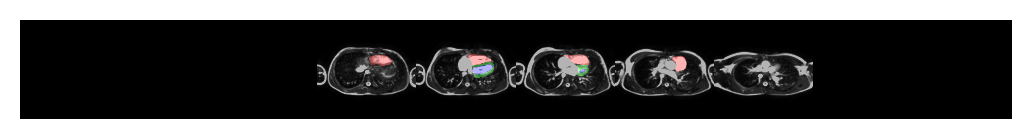

2020-11-27 20:00:15,685 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:00:15,764 INFO DICE LV: 0.8477782607078552
2020-11-27 20:00:15,844 INFO DICE RV: 0.8149577379226685
2020-11-27 20:00:15,922 INFO DICE MYO: 0.7061296701431274
2020-11-27 20:00:15,975 INFO m: [[ 0.4736  -0.8354  -0.2798  -0.999  ]
 [ 0.3467  -0.11554  0.931   -0.996  ]
 [-0.81    -0.538    0.2349  15.016  ]]
2020-11-27 20:00:15,975 INFO m_mod: [[ 0.4736  -0.8354  -0.2798  -0.4634 ]
 [ 0.3467  -0.11554  0.931    0.883  ]
 [-0.81    -0.538    0.2349   1.242  ]]
2020-11-27 20:00:15,976 INFO m_scaled: [[ 0.4736  -0.8354  -0.2798  -0.927  ]
 [ 0.3467  -0.11554  0.931    1.766  ]
 [-0.81    -0.538    0.2349   2.484  ]]
2020-11-27 20:00:15,977 INFO 0000-3EX293QC_2006-06-19_ED_msk.nrrd
2020-11-27 20:00:15,977 INFO Prediction on AX volume:
2020-11-27 20:00:16,666 INFO AX --> SAX rotated by the model
2020-11-27 20:00:16,666 INFO AX --> SAX with modified m rotated by the model
2020-11-27

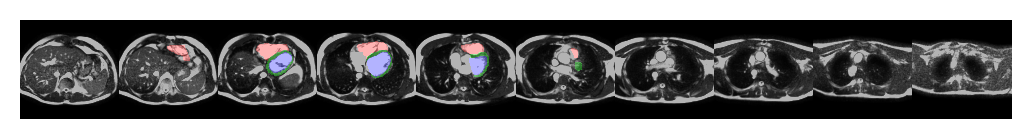

2020-11-27 20:00:21,946 INFO GT on AX


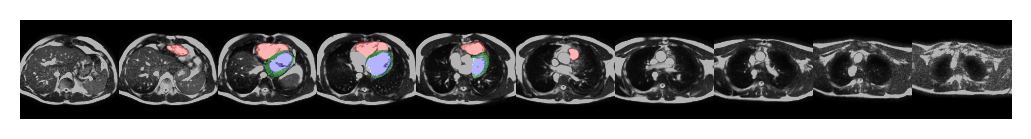

2020-11-27 20:00:22,365 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:00:22,450 INFO DICE LV: 0.9267370700836182
2020-11-27 20:00:22,530 INFO DICE RV: 0.881801187992096
2020-11-27 20:00:22,610 INFO DICE MYO: 0.7328510284423828
2020-11-27 20:00:22,666 INFO m: [[ 0.4678 -0.8276 -0.31   -0.999 ]
 [ 0.3486 -0.1493  0.9253 -0.9966]
 [-0.812  -0.541   0.2188 15.375 ]]
2020-11-27 20:00:22,666 INFO m_mod: [[ 0.4678 -0.8276 -0.31   -0.4712]
 [ 0.3486 -0.1493  0.9253  0.904 ]
 [-0.812  -0.541   0.2188  1.272 ]]
2020-11-27 20:00:22,667 INFO m_scaled: [[ 0.4678 -0.8276 -0.31   -0.9424]
 [ 0.3486 -0.1493  0.9253  1.808 ]
 [-0.812  -0.541   0.2188  2.545 ]]
2020-11-27 20:00:22,669 INFO 0000-3EX293QC_2006-06-19_ES_msk.nrrd
2020-11-27 20:00:22,669 INFO Prediction on AX volume:
2020-11-27 20:00:23,342 INFO AX --> SAX rotated by the model
2020-11-27 20:00:23,343 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:00:23,369 INFO Target (AX2SAX):
2

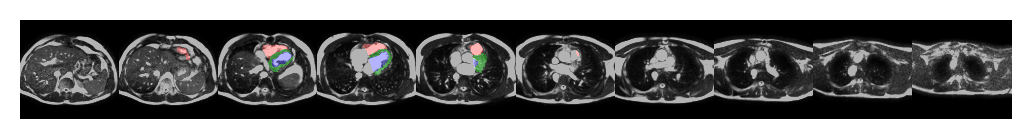

2020-11-27 20:00:28,625 INFO GT on AX


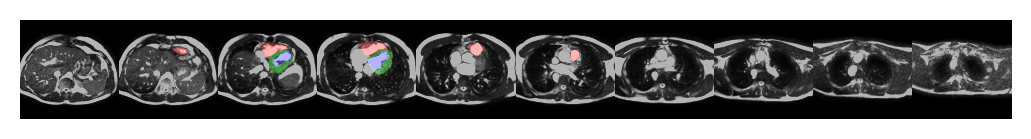

2020-11-27 20:00:29,040 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:00:29,125 INFO DICE LV: 0.8716530203819275
2020-11-27 20:00:29,204 INFO DICE RV: 0.7864862084388733
2020-11-27 20:00:29,283 INFO DICE MYO: 0.6886206865310669
2020-11-27 20:00:29,337 INFO m: [[ 0.47   -0.8315 -0.2961 -0.999 ]
 [ 0.3477 -0.1339  0.928  -0.996 ]
 [-0.811  -0.539   0.2261 15.22  ]]
2020-11-27 20:00:29,337 INFO m_mod: [[ 0.47   -0.8315 -0.2961 -0.4678]
 [ 0.3477 -0.1339  0.928   0.8945]
 [-0.811  -0.539   0.2261  1.259 ]]
2020-11-27 20:00:29,338 INFO m_scaled: [[ 0.47   -0.8315 -0.2961 -0.9355]
 [ 0.3477 -0.1339  0.928   1.789 ]
 [-0.811  -0.539   0.2261  2.518 ]]
2020-11-27 20:00:29,338 INFO 0000-5RMHZGWP_2006-08-03_ED_msk.nrrd
2020-11-27 20:00:29,339 INFO Prediction on AX volume:
2020-11-27 20:00:30,012 INFO AX --> SAX rotated by the model
2020-11-27 20:00:30,012 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:00:30,041 INFO Target (AX2SAX):


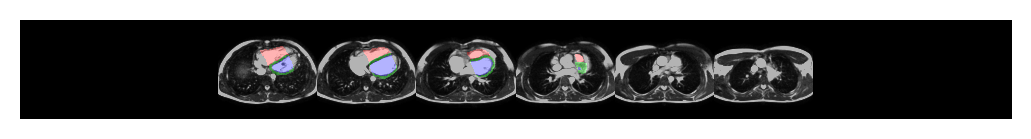

2020-11-27 20:00:35,269 INFO GT on AX


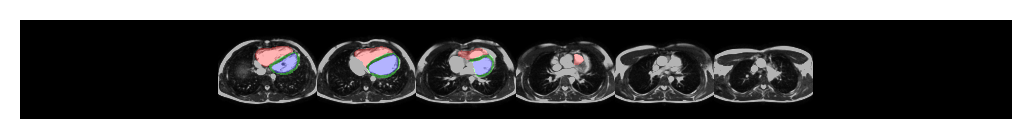

2020-11-27 20:00:35,675 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:00:35,761 INFO DICE LV: 0.8797149062156677
2020-11-27 20:00:35,841 INFO DICE RV: 0.68449467420578
2020-11-27 20:00:35,920 INFO DICE MYO: 0.6406133770942688
2020-11-27 20:00:35,974 INFO m: [[ 0.4692 -0.829  -0.3037 -0.999 ]
 [ 0.3484 -0.1421  0.9263 -0.9966]
 [-0.8115 -0.5405  0.2223 15.3   ]]
2020-11-27 20:00:35,975 INFO m_mod: [[ 0.4692 -0.829  -0.3037 -0.4697]
 [ 0.3484 -0.1421  0.9263  0.8994]
 [-0.8115 -0.5405  0.2223  1.266 ]]
2020-11-27 20:00:35,975 INFO m_scaled: [[ 0.4692 -0.829  -0.3037 -0.9395]
 [ 0.3484 -0.1421  0.9263  1.799 ]
 [-0.8115 -0.5405  0.2223  2.531 ]]
2020-11-27 20:00:35,976 INFO 0000-5RMHZGWP_2006-08-03_ES_msk.nrrd
2020-11-27 20:00:35,976 INFO Prediction on AX volume:
2020-11-27 20:00:36,666 INFO AX --> SAX rotated by the model
2020-11-27 20:00:36,668 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:00:36,712 INFO Target (AX2SAX):
20

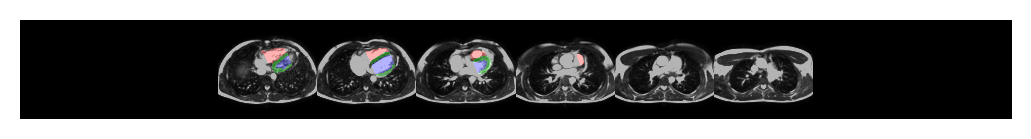

2020-11-27 20:00:41,953 INFO GT on AX


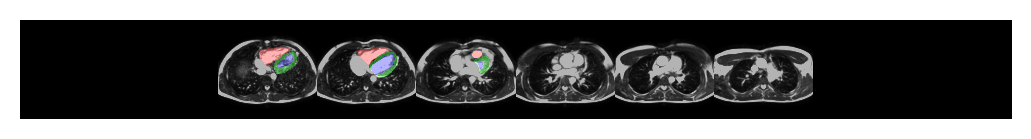

2020-11-27 20:00:42,364 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:00:42,451 INFO DICE LV: 0.8277934789657593
2020-11-27 20:00:42,531 INFO DICE RV: 0.6670050024986267
2020-11-27 20:00:42,611 INFO DICE MYO: 0.6260793209075928
2020-11-27 20:00:42,665 INFO m: [[ 0.4697 -0.831  -0.2976 -0.999 ]
 [ 0.3477 -0.1351  0.9277 -0.996 ]
 [-0.811  -0.5396  0.2255 15.234 ]]
2020-11-27 20:00:42,666 INFO m_mod: [[ 0.4697 -0.831  -0.2976 -0.4683]
 [ 0.3477 -0.1351  0.9277  0.8955]
 [-0.811  -0.5396  0.2255  1.26  ]]
2020-11-27 20:00:42,666 INFO m_scaled: [[ 0.4697 -0.831  -0.2976 -0.9365]
 [ 0.3477 -0.1351  0.9277  1.791 ]
 [-0.811  -0.5396  0.2255  2.52  ]]
2020-11-27 20:00:42,667 INFO 0000-5W8RFCJD_2005-04-18_ED_msk.nrrd
2020-11-27 20:00:42,668 INFO Prediction on AX volume:
2020-11-27 20:00:43,322 INFO AX --> SAX rotated by the model
2020-11-27 20:00:43,322 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:00:43,345 INFO Target (AX2SAX):


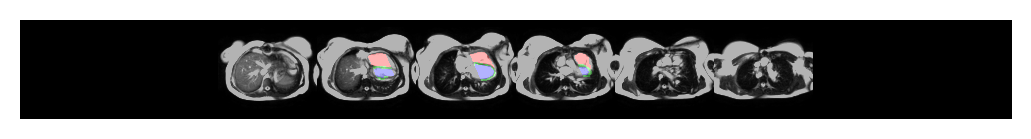

2020-11-27 20:00:48,584 INFO GT on AX


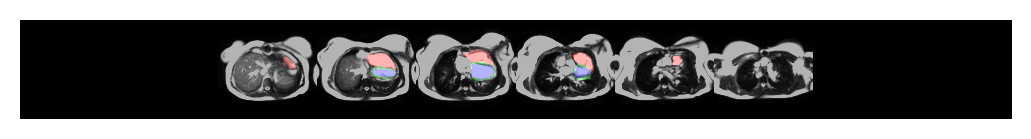

2020-11-27 20:00:48,998 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:00:49,083 INFO DICE LV: 0.7531785368919373
2020-11-27 20:00:49,163 INFO DICE RV: 0.7293097376823425
2020-11-27 20:00:49,243 INFO DICE MYO: 0.45563268661499023
2020-11-27 20:00:49,297 INFO m: [[ 0.4722 -0.833  -0.2886 -0.999 ]
 [ 0.3474 -0.1252  0.9297 -0.996 ]
 [-0.8105 -0.5386  0.2302 15.11  ]]
2020-11-27 20:00:49,297 INFO m_mod: [[ 0.4722 -0.833  -0.2886 -0.4653]
 [ 0.3474 -0.1252  0.9297  0.888 ]
 [-0.8105 -0.5386  0.2302  1.249 ]]
2020-11-27 20:00:49,298 INFO m_scaled: [[ 0.4722 -0.833  -0.2886 -0.9307]
 [ 0.3474 -0.1252  0.9297  1.776 ]
 [-0.8105 -0.5386  0.2302  2.498 ]]
2020-11-27 20:00:49,299 INFO 0000-5W8RFCJD_2005-04-18_ES_msk.nrrd
2020-11-27 20:00:49,299 INFO Prediction on AX volume:
2020-11-27 20:00:49,971 INFO AX --> SAX rotated by the model
2020-11-27 20:00:49,971 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:00:49,991 INFO Target (AX2SAX):

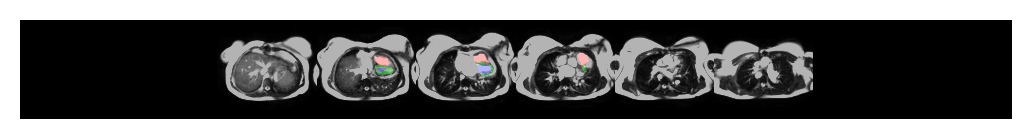

2020-11-27 20:00:55,208 INFO GT on AX


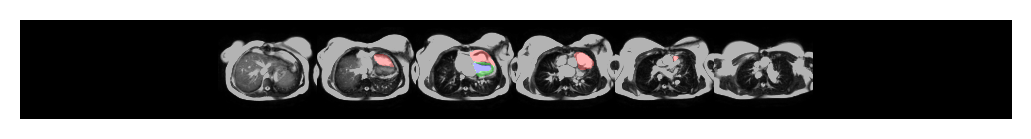

2020-11-27 20:00:55,617 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:00:55,697 INFO DICE LV: 0.7360970973968506
2020-11-27 20:00:55,776 INFO DICE RV: 0.574024498462677
2020-11-27 20:00:55,856 INFO DICE MYO: 0.49573540687561035
2020-11-27 20:00:55,911 INFO m: [[ 0.4724 -0.834  -0.286  -0.999 ]
 [ 0.3474 -0.1221  0.9297 -0.996 ]
 [-0.81   -0.5386  0.2319 15.07  ]]
2020-11-27 20:00:55,911 INFO m_mod: [[ 0.4724 -0.834  -0.286  -0.4644]
 [ 0.3474 -0.1221  0.9297  0.8857]
 [-0.81   -0.5386  0.2319  1.246 ]]
2020-11-27 20:00:55,912 INFO m_scaled: [[ 0.4724 -0.834  -0.286  -0.9287]
 [ 0.3474 -0.1221  0.9297  1.771 ]
 [-0.81   -0.5386  0.2319  2.492 ]]
2020-11-27 20:00:55,912 INFO 0000-DLTVKE94_2006-07-18_ED_msk.nrrd
2020-11-27 20:00:55,913 INFO Prediction on AX volume:
2020-11-27 20:00:56,604 INFO AX --> SAX rotated by the model
2020-11-27 20:00:56,607 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:00:56,655 INFO Target (AX2SAX):


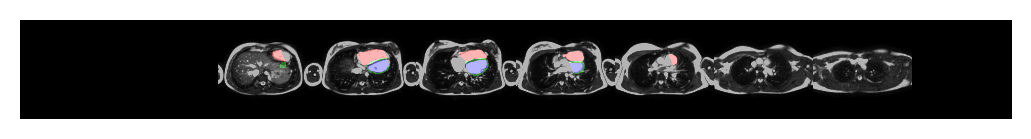

2020-11-27 20:01:01,893 INFO GT on AX


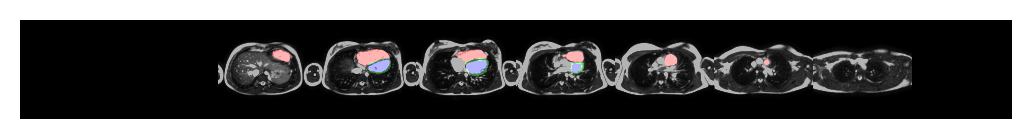

2020-11-27 20:01:02,319 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:01:02,405 INFO DICE LV: 0.909416913986206
2020-11-27 20:01:02,487 INFO DICE RV: 0.840066134929657
2020-11-27 20:01:02,568 INFO DICE MYO: 0.6470460295677185
2020-11-27 20:01:02,622 INFO m: [[ 0.4749 -0.8374 -0.2695 -0.999 ]
 [ 0.3457 -0.1037  0.9326 -0.9956]
 [-0.809  -0.536   0.2402 14.9   ]]
2020-11-27 20:01:02,623 INFO m_mod: [[ 0.4749 -0.8374 -0.2695 -0.4604]
 [ 0.3457 -0.1037  0.9326  0.8755]
 [-0.809  -0.536   0.2402  1.232 ]]
2020-11-27 20:01:02,623 INFO m_scaled: [[ 0.4749 -0.8374 -0.2695 -0.921 ]
 [ 0.3457 -0.1037  0.9326  1.751 ]
 [-0.809  -0.536   0.2402  2.465 ]]
2020-11-27 20:01:02,624 INFO 0000-DLTVKE94_2006-07-18_ES_msk.nrrd
2020-11-27 20:01:02,624 INFO Prediction on AX volume:
2020-11-27 20:01:03,297 INFO AX --> SAX rotated by the model
2020-11-27 20:01:03,300 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:01:03,342 INFO Target (AX2SAX):
20

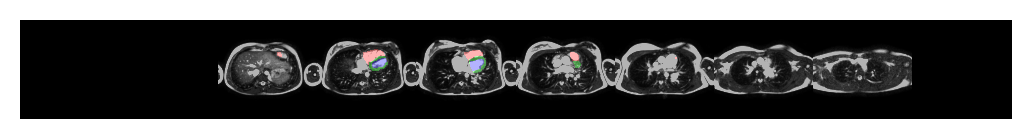

2020-11-27 20:01:08,567 INFO GT on AX


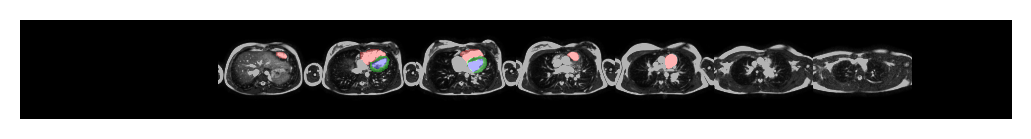

2020-11-27 20:01:08,983 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:01:09,070 INFO DICE LV: 0.8040163516998291
2020-11-27 20:01:09,150 INFO DICE RV: 0.7065900564193726
2020-11-27 20:01:09,231 INFO DICE MYO: 0.6936825513839722
2020-11-27 20:01:09,284 INFO m: [[ 0.477   -0.84    -0.2605  -0.9985 ]
 [ 0.3452  -0.09406  0.934   -0.9956 ]
 [-0.8086  -0.535    0.2451  14.8    ]]
2020-11-27 20:01:09,285 INFO m_mod: [[ 0.477   -0.84    -0.2605  -0.4585 ]
 [ 0.3452  -0.09406  0.934    0.87   ]
 [-0.8086  -0.535    0.2451   1.224  ]]
2020-11-27 20:01:09,286 INFO m_scaled: [[ 0.477   -0.84    -0.2605  -0.917  ]
 [ 0.3452  -0.09406  0.934    1.74   ]
 [-0.8086  -0.535    0.2451   2.447  ]]
2020-11-27 20:01:09,287 INFO 0000-E0RJZQQM_2005-09-30_ED_msk.nrrd
2020-11-27 20:01:09,288 INFO Prediction on AX volume:
2020-11-27 20:01:09,945 INFO AX --> SAX rotated by the model
2020-11-27 20:01:09,946 INFO AX --> SAX with modified m rotated by the model
2020-11-27

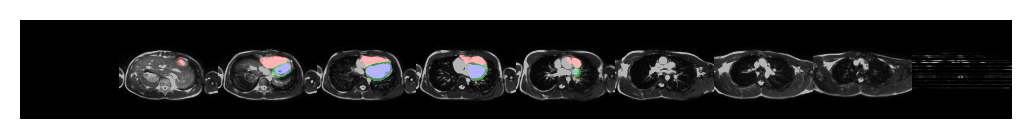

2020-11-27 20:01:15,170 INFO GT on AX


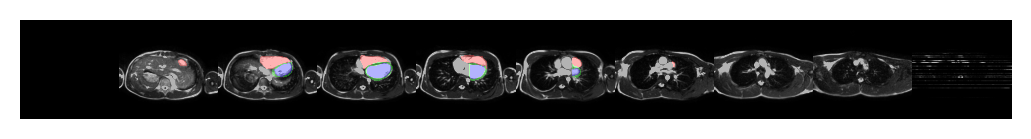

2020-11-27 20:01:15,572 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:01:15,650 INFO DICE LV: 0.9120660424232483
2020-11-27 20:01:15,728 INFO DICE RV: 0.8161400556564331
2020-11-27 20:01:15,807 INFO DICE MYO: 0.6369737982749939
2020-11-27 20:01:15,861 INFO m: [[ 0.4695 -0.83   -0.3015 -0.999 ]
 [ 0.3481 -0.1399  0.9272 -0.996 ]
 [-0.8115 -0.54    0.2233 15.266 ]]
2020-11-27 20:01:15,862 INFO m_mod: [[ 0.4695 -0.83   -0.3015 -0.4688]
 [ 0.3481 -0.1399  0.9272  0.8975]
 [-0.8115 -0.54    0.2233  1.263 ]]
2020-11-27 20:01:15,863 INFO m_scaled: [[ 0.4695 -0.83   -0.3015 -0.9375]
 [ 0.3481 -0.1399  0.9272  1.795 ]
 [-0.8115 -0.54    0.2233  2.525 ]]
2020-11-27 20:01:15,863 INFO 0000-E0RJZQQM_2005-09-30_ES_msk.nrrd
2020-11-27 20:01:15,864 INFO Prediction on AX volume:
2020-11-27 20:01:16,533 INFO AX --> SAX rotated by the model
2020-11-27 20:01:16,534 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:01:16,554 INFO Target (AX2SAX):


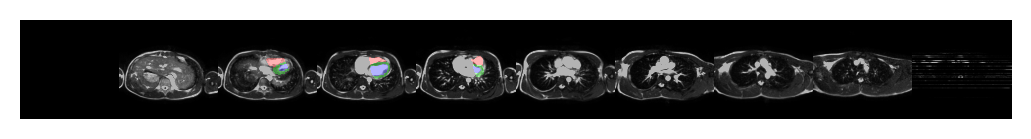

2020-11-27 20:01:21,818 INFO GT on AX


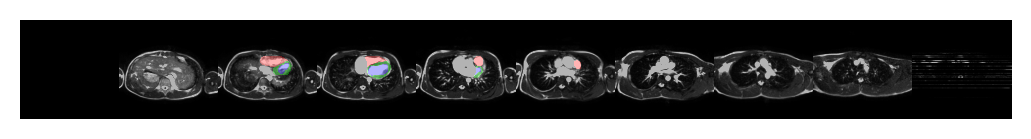

2020-11-27 20:01:22,239 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:01:22,320 INFO DICE LV: 0.8544308543205261
2020-11-27 20:01:22,400 INFO DICE RV: 0.6051673889160156
2020-11-27 20:01:22,480 INFO DICE MYO: 0.6528575420379639
2020-11-27 20:01:22,535 INFO m: [[ 0.4692 -0.829  -0.3037 -0.999 ]
 [ 0.3484 -0.1421  0.9263 -0.996 ]
 [-0.8115 -0.5405  0.2223 15.29  ]]
2020-11-27 20:01:22,535 INFO m_mod: [[ 0.4692 -0.829  -0.3037 -0.4692]
 [ 0.3484 -0.1421  0.9263  0.899 ]
 [-0.8115 -0.5405  0.2223  1.265 ]]
2020-11-27 20:01:22,536 INFO m_scaled: [[ 0.4692 -0.829  -0.3037 -0.9385]
 [ 0.3484 -0.1421  0.9263  1.798 ]
 [-0.8115 -0.5405  0.2223  2.53  ]]
2020-11-27 20:01:22,537 INFO 0000-E24LRCWD_2006-11-23_ED_msk.nrrd
2020-11-27 20:01:22,538 INFO Prediction on AX volume:
2020-11-27 20:01:23,210 INFO AX --> SAX rotated by the model
2020-11-27 20:01:23,211 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:01:23,247 INFO Target (AX2SAX):


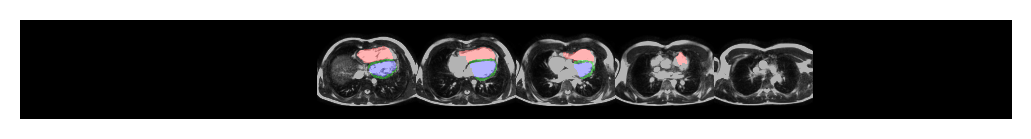

2020-11-27 20:01:28,522 INFO GT on AX


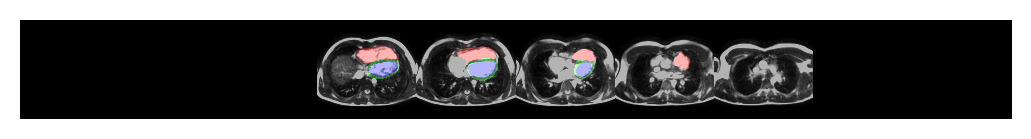

2020-11-27 20:01:28,930 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:01:29,006 INFO DICE LV: 0.8935388922691345
2020-11-27 20:01:29,082 INFO DICE RV: 0.8322193026542664
2020-11-27 20:01:29,159 INFO DICE MYO: 0.6681276559829712
2020-11-27 20:01:29,213 INFO m: [[ 0.4685 -0.8286 -0.3064 -0.999 ]
 [ 0.3484 -0.1456  0.926  -0.9966]
 [-0.812  -0.5405  0.2206 15.336 ]]
2020-11-27 20:01:29,214 INFO m_mod: [[ 0.4685 -0.8286 -0.3064 -0.4702]
 [ 0.3484 -0.1456  0.926   0.902 ]
 [-0.812  -0.5405  0.2206  1.269 ]]
2020-11-27 20:01:29,214 INFO m_scaled: [[ 0.4685 -0.8286 -0.3064 -0.9404]
 [ 0.3484 -0.1456  0.926   1.804 ]
 [-0.812  -0.5405  0.2206  2.537 ]]
2020-11-27 20:01:29,215 INFO 0000-E24LRCWD_2006-11-23_ES_msk.nrrd
2020-11-27 20:01:29,215 INFO Prediction on AX volume:
2020-11-27 20:01:29,892 INFO AX --> SAX rotated by the model
2020-11-27 20:01:29,894 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:01:29,937 INFO Target (AX2SAX):


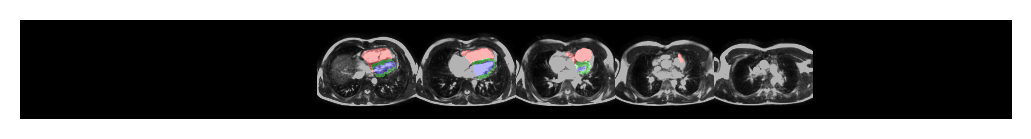

2020-11-27 20:01:37,809 INFO GT on AX


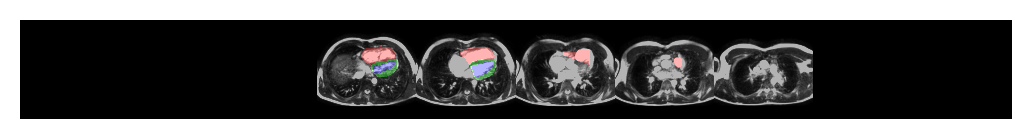

2020-11-27 20:01:38,217 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:01:38,280 INFO DICE LV: 0.8623934984207153
2020-11-27 20:01:38,343 INFO DICE RV: 0.8110491633415222
2020-11-27 20:01:38,404 INFO DICE MYO: 0.6466706395149231
2020-11-27 20:01:38,445 INFO m: [[ 0.4707 -0.8315 -0.2944 -0.999 ]
 [ 0.3474 -0.1321  0.928  -0.996 ]
 [-0.811  -0.539   0.2267 15.195 ]]
2020-11-27 20:01:38,445 INFO m_mod: [[ 0.4707 -0.8315 -0.2944 -0.4673]
 [ 0.3474 -0.1321  0.928   0.893 ]
 [-0.811  -0.539   0.2267  1.257 ]]
2020-11-27 20:01:38,446 INFO m_scaled: [[ 0.4707 -0.8315 -0.2944 -0.9346]
 [ 0.3474 -0.1321  0.928   1.786 ]
 [-0.811  -0.539   0.2267  2.514 ]]
2020-11-27 20:01:38,447 INFO 0000-FANDNZ55_2007-02-19_ED_msk.nrrd
2020-11-27 20:01:38,447 INFO Prediction on AX volume:
2020-11-27 20:01:39,114 INFO AX --> SAX rotated by the model
2020-11-27 20:01:39,115 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:01:39,141 INFO Target (AX2SAX):


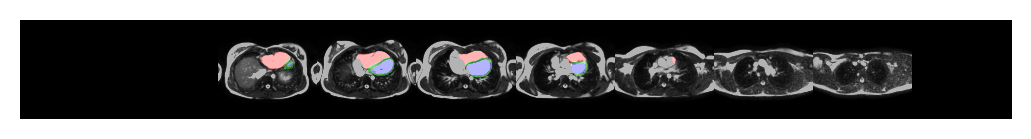

2020-11-27 20:01:44,578 INFO GT on AX


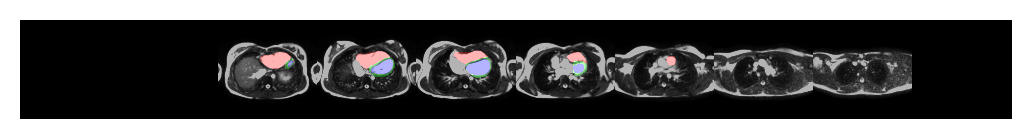

2020-11-27 20:01:44,986 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:01:45,051 INFO DICE LV: 0.9334667325019836
2020-11-27 20:01:45,117 INFO DICE RV: 0.8660450577735901
2020-11-27 20:01:45,180 INFO DICE MYO: 0.7016848921775818
2020-11-27 20:01:45,219 INFO m: [[ 0.467  -0.827  -0.3135 -0.999 ]
 [ 0.349  -0.1534  0.925  -0.9966]
 [-0.8125 -0.541   0.2169 15.41  ]]
2020-11-27 20:01:45,220 INFO m_mod: [[ 0.467  -0.827  -0.3135 -0.4717]
 [ 0.349  -0.1534  0.925   0.9053]
 [-0.8125 -0.541   0.2169  1.274 ]]
2020-11-27 20:01:45,220 INFO m_scaled: [[ 0.467  -0.827  -0.3135 -0.9434]
 [ 0.349  -0.1534  0.925   1.811 ]
 [-0.8125 -0.541   0.2169  2.549 ]]
2020-11-27 20:01:45,221 INFO 0000-FANDNZ55_2007-02-19_ES_msk.nrrd
2020-11-27 20:01:45,221 INFO Prediction on AX volume:
2020-11-27 20:01:45,925 INFO AX --> SAX rotated by the model
2020-11-27 20:01:45,928 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:01:45,974 INFO Target (AX2SAX):


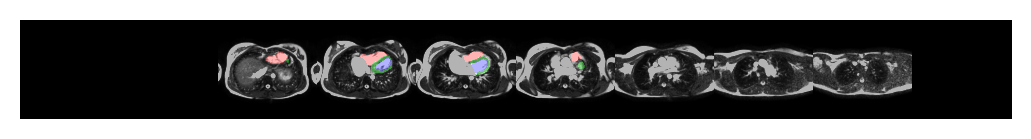

2020-11-27 20:01:51,261 INFO GT on AX


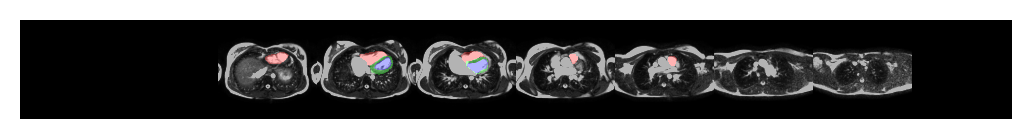

2020-11-27 20:01:51,665 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:01:51,732 INFO DICE LV: 0.8617725372314453
2020-11-27 20:01:51,798 INFO DICE RV: 0.8293970227241516
2020-11-27 20:01:51,863 INFO DICE MYO: 0.7405675649642944
2020-11-27 20:01:51,903 INFO m: [[ 0.4695 -0.83   -0.3015 -0.999 ]
 [ 0.3481 -0.1399  0.9272 -0.996 ]
 [-0.8115 -0.54    0.2233 15.27  ]]
2020-11-27 20:01:51,904 INFO m_mod: [[ 0.4695 -0.83   -0.3015 -0.4688]
 [ 0.3481 -0.1399  0.9272  0.8975]
 [-0.8115 -0.54    0.2233  1.263 ]]
2020-11-27 20:01:51,904 INFO m_scaled: [[ 0.4695 -0.83   -0.3015 -0.9375]
 [ 0.3481 -0.1399  0.9272  1.795 ]
 [-0.8115 -0.54    0.2233  2.525 ]]
2020-11-27 20:01:51,905 INFO 0000-FHQU30DQ_2005-05-10_ED_msk.nrrd
2020-11-27 20:01:51,905 INFO Prediction on AX volume:
2020-11-27 20:01:52,575 INFO AX --> SAX rotated by the model
2020-11-27 20:01:52,576 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:01:52,596 INFO Target (AX2SAX):


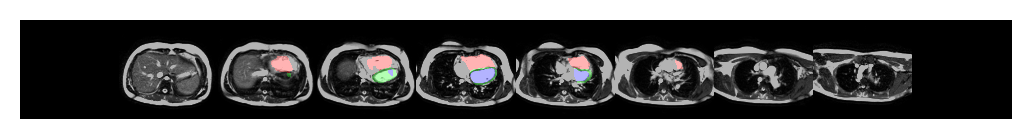

2020-11-27 20:01:57,792 INFO GT on AX


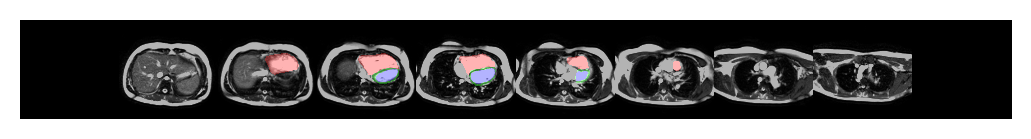

2020-11-27 20:01:58,202 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:01:58,270 INFO DICE LV: 0.8419251441955566
2020-11-27 20:01:58,336 INFO DICE RV: 0.780390202999115
2020-11-27 20:01:58,402 INFO DICE MYO: 0.5515784621238708
2020-11-27 20:01:58,442 INFO m: [[ 0.474   -0.8364  -0.2756  -0.999  ]
 [ 0.3462  -0.11127  0.9316  -0.996  ]
 [-0.81    -0.537    0.2368  14.99   ]]
2020-11-27 20:01:58,443 INFO m_mod: [[ 0.474   -0.8364  -0.2756  -0.4624 ]
 [ 0.3462  -0.11127  0.9316   0.8813 ]
 [-0.81    -0.537    0.2368   1.24   ]]
2020-11-27 20:01:58,444 INFO m_scaled: [[ 0.474   -0.8364  -0.2756  -0.925  ]
 [ 0.3462  -0.11127  0.9316   1.763  ]
 [-0.81    -0.537    0.2368   2.48   ]]
2020-11-27 20:01:58,444 INFO 0000-FHQU30DQ_2005-05-10_ES_msk.nrrd
2020-11-27 20:01:58,445 INFO Prediction on AX volume:
2020-11-27 20:01:59,112 INFO AX --> SAX rotated by the model
2020-11-27 20:01:59,115 INFO AX --> SAX with modified m rotated by the model
2020-11-27 

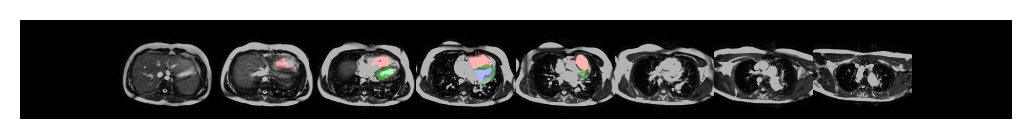

2020-11-27 20:02:04,326 INFO GT on AX


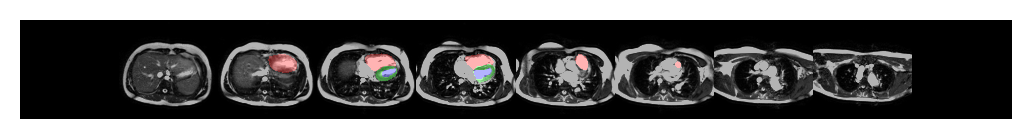

2020-11-27 20:02:04,731 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:02:04,798 INFO DICE LV: 0.7007166147232056
2020-11-27 20:02:04,865 INFO DICE RV: 0.6772042512893677
2020-11-27 20:02:04,929 INFO DICE MYO: 0.609332799911499
2020-11-27 20:02:04,970 INFO m: [[ 0.4756  -0.839   -0.2651  -0.999  ]
 [ 0.3452  -0.09924  0.933   -0.9956 ]
 [-0.809   -0.5356   0.2426  14.875  ]]
2020-11-27 20:02:04,970 INFO m_mod: [[ 0.4756  -0.839   -0.2651  -0.46   ]
 [ 0.3452  -0.09924  0.933    0.875  ]
 [-0.809   -0.5356   0.2426   1.231  ]]
2020-11-27 20:02:04,971 INFO m_scaled: [[ 0.4756  -0.839   -0.2651  -0.92   ]
 [ 0.3452  -0.09924  0.933    1.75   ]
 [-0.809   -0.5356   0.2426   2.463  ]]
2020-11-27 20:02:04,972 INFO 0000-G8XJ03CH_2007-10-31_ED_msk.nrrd
2020-11-27 20:02:04,972 INFO Prediction on AX volume:
2020-11-27 20:02:05,644 INFO AX --> SAX rotated by the model
2020-11-27 20:02:05,645 INFO AX --> SAX with modified m rotated by the model
2020-11-27 

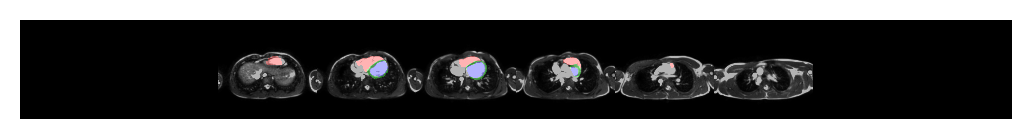

2020-11-27 20:02:10,848 INFO GT on AX


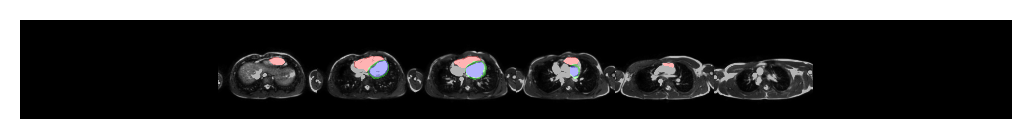

2020-11-27 20:02:11,250 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:02:11,318 INFO DICE LV: 0.9103319048881531
2020-11-27 20:02:11,384 INFO DICE RV: 0.8416944146156311
2020-11-27 20:02:11,449 INFO DICE MYO: 0.6472787857055664
2020-11-27 20:02:11,489 INFO m: [[ 0.4697 -0.8306 -0.298  -0.999 ]
 [ 0.3477 -0.136   0.9272 -0.996 ]
 [-0.811  -0.5396  0.2249 15.23  ]]
2020-11-27 20:02:11,490 INFO m_mod: [[ 0.4697 -0.8306 -0.298  -0.4683]
 [ 0.3477 -0.136   0.9272  0.895 ]
 [-0.811  -0.5396  0.2249  1.259 ]]
2020-11-27 20:02:11,490 INFO m_scaled: [[ 0.4697 -0.8306 -0.298  -0.9365]
 [ 0.3477 -0.136   0.9272  1.79  ]
 [-0.811  -0.5396  0.2249  2.518 ]]
2020-11-27 20:02:11,490 INFO 0000-G8XJ03CH_2007-10-31_ES_msk.nrrd
2020-11-27 20:02:11,491 INFO Prediction on AX volume:
2020-11-27 20:02:12,144 INFO AX --> SAX rotated by the model
2020-11-27 20:02:12,144 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:02:12,164 INFO Target (AX2SAX):


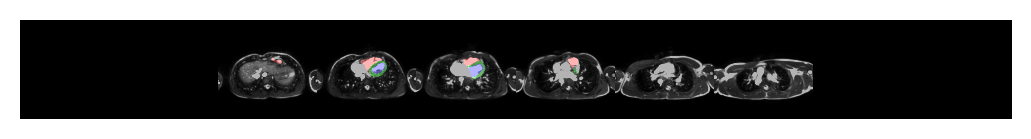

2020-11-27 20:02:18,300 INFO GT on AX


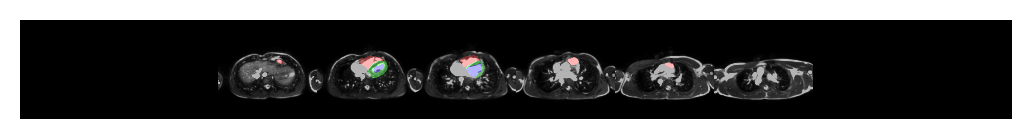

2020-11-27 20:02:18,709 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:02:18,772 INFO DICE LV: 0.8614927530288696
2020-11-27 20:02:18,835 INFO DICE RV: 0.7908381223678589
2020-11-27 20:02:18,897 INFO DICE MYO: 0.748338520526886
2020-11-27 20:02:18,937 INFO m: [[ 0.4705 -0.8315 -0.2961 -0.999 ]
 [ 0.348  -0.1339  0.928  -0.996 ]
 [-0.811  -0.5396  0.2262 15.195 ]]
2020-11-27 20:02:18,937 INFO m_mod: [[ 0.4705 -0.8315 -0.2961 -0.4673]
 [ 0.348  -0.1339  0.928   0.893 ]
 [-0.811  -0.5396  0.2262  1.257 ]]
2020-11-27 20:02:18,938 INFO m_scaled: [[ 0.4705 -0.8315 -0.2961 -0.9346]
 [ 0.348  -0.1339  0.928   1.786 ]
 [-0.811  -0.5396  0.2262  2.514 ]]
2020-11-27 20:02:18,938 INFO 0000-GYMP57R6_2006-12-18_ED_msk.nrrd
2020-11-27 20:02:18,939 INFO Prediction on AX volume:
2020-11-27 20:02:19,605 INFO AX --> SAX rotated by the model
2020-11-27 20:02:19,605 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:02:19,628 INFO Target (AX2SAX):
2

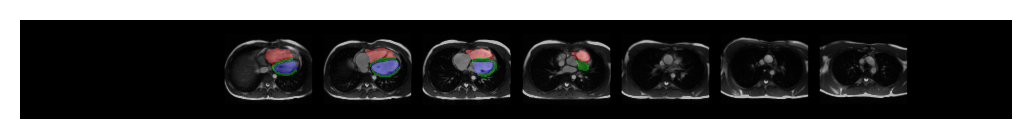

2020-11-27 20:02:24,758 INFO GT on AX


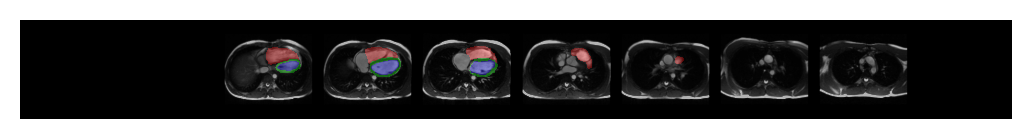

2020-11-27 20:02:25,168 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:02:25,231 INFO DICE LV: 0.8970901370048523
2020-11-27 20:02:25,296 INFO DICE RV: 0.7893609404563904
2020-11-27 20:02:25,357 INFO DICE MYO: 0.6912012100219727
2020-11-27 20:02:25,398 INFO m: [[ 0.4587 -0.8115 -0.3618 -0.9995]
 [ 0.3525 -0.2072  0.9126 -0.997 ]
 [-0.8154 -0.546   0.191  15.984 ]]
2020-11-27 20:02:25,399 INFO m_mod: [[ 0.4587 -0.8115 -0.3618 -0.4844]
 [ 0.3525 -0.2072  0.9126  0.9395]
 [-0.8154 -0.546   0.191   1.321 ]]
2020-11-27 20:02:25,399 INFO m_scaled: [[ 0.4587 -0.8115 -0.3618 -0.9688]
 [ 0.3525 -0.2072  0.9126  1.879 ]
 [-0.8154 -0.546   0.191   2.643 ]]
2020-11-27 20:02:25,399 INFO 0000-GYMP57R6_2006-12-18_ES_msk.nrrd
2020-11-27 20:02:25,400 INFO Prediction on AX volume:
2020-11-27 20:02:26,058 INFO AX --> SAX rotated by the model
2020-11-27 20:02:26,059 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:02:26,081 INFO Target (AX2SAX):


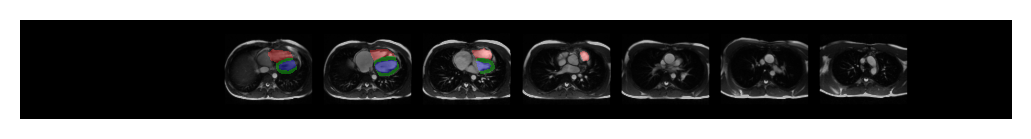

2020-11-27 20:02:31,222 INFO GT on AX


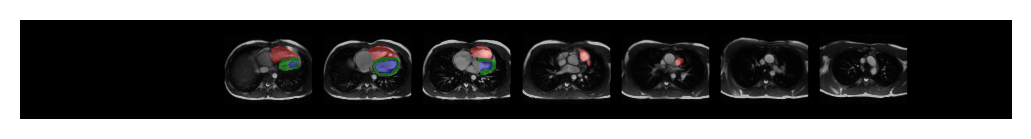

2020-11-27 20:02:31,632 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:02:31,699 INFO DICE LV: 0.870302140712738
2020-11-27 20:02:31,765 INFO DICE RV: 0.7187971472740173
2020-11-27 20:02:31,830 INFO DICE MYO: 0.7329139113426208
2020-11-27 20:02:31,870 INFO m: [[ 0.4597 -0.8135 -0.3562 -0.999 ]
 [ 0.352  -0.2014  0.914  -0.997 ]
 [-0.8154 -0.546   0.1938 15.92  ]]
2020-11-27 20:02:31,871 INFO m_mod: [[ 0.4597 -0.8135 -0.3562 -0.4834]
 [ 0.352  -0.2014  0.914   0.936 ]
 [-0.8154 -0.546   0.1938  1.316 ]]
2020-11-27 20:02:31,871 INFO m_scaled: [[ 0.4597 -0.8135 -0.3562 -0.967 ]
 [ 0.352  -0.2014  0.914   1.872 ]
 [-0.8154 -0.546   0.1938  2.633 ]]
2020-11-27 20:02:31,872 INFO 0000-GYRF6ZAA_2004-08-01_ED_msk.nrrd
2020-11-27 20:02:31,872 INFO Prediction on AX volume:
2020-11-27 20:02:32,559 INFO AX --> SAX rotated by the model
2020-11-27 20:02:32,562 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:02:32,626 INFO Target (AX2SAX):
2

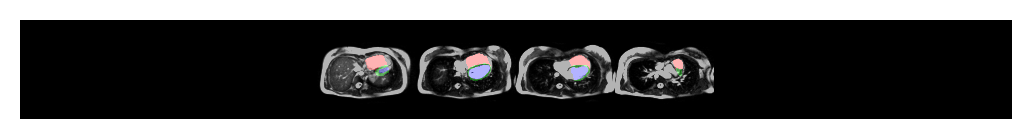

2020-11-27 20:02:37,733 INFO GT on AX


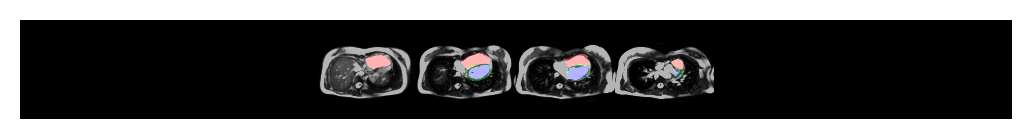

2020-11-27 20:02:38,132 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:02:38,199 INFO DICE LV: 0.8942832350730896
2020-11-27 20:02:38,267 INFO DICE RV: 0.8309096097946167
2020-11-27 20:02:38,333 INFO DICE MYO: 0.6457239389419556
2020-11-27 20:02:38,373 INFO m: [[ 0.474  -0.8364 -0.2764 -0.999 ]
 [ 0.3462 -0.1122  0.932  -0.996 ]
 [-0.81   -0.537   0.2365 14.984 ]]
2020-11-27 20:02:38,374 INFO m_mod: [[ 0.474  -0.8364 -0.2764 -0.4624]
 [ 0.3462 -0.1122  0.932   0.881 ]
 [-0.81   -0.537   0.2365  1.239 ]]
2020-11-27 20:02:38,374 INFO m_scaled: [[ 0.474  -0.8364 -0.2764 -0.925 ]
 [ 0.3462 -0.1122  0.932   1.762 ]
 [-0.81   -0.537   0.2365  2.479 ]]
2020-11-27 20:02:38,375 INFO 0000-GYRF6ZAA_2004-08-01_ES_msk.nrrd
2020-11-27 20:02:38,375 INFO Prediction on AX volume:
2020-11-27 20:02:39,058 INFO AX --> SAX rotated by the model
2020-11-27 20:02:39,059 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:02:39,090 INFO Target (AX2SAX):


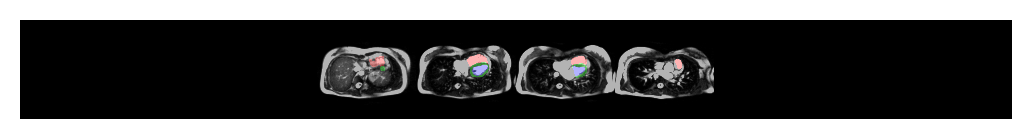

2020-11-27 20:02:44,224 INFO GT on AX


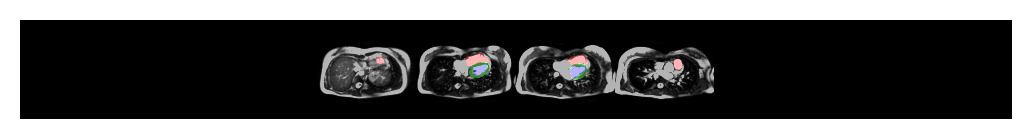

2020-11-27 20:02:44,629 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:02:44,695 INFO DICE LV: 0.8146333694458008
2020-11-27 20:02:44,760 INFO DICE RV: 0.8176353573799133
2020-11-27 20:02:44,826 INFO DICE MYO: 0.7342313528060913
2020-11-27 20:02:44,866 INFO m: [[ 0.4736  -0.8354  -0.2798  -0.999  ]
 [ 0.3467  -0.11554  0.931   -0.996  ]
 [-0.81    -0.538    0.2349  15.02   ]]
2020-11-27 20:02:44,866 INFO m_mod: [[ 0.4736  -0.8354  -0.2798  -0.4634 ]
 [ 0.3467  -0.11554  0.931    0.883  ]
 [-0.81    -0.538    0.2349   1.242  ]]
2020-11-27 20:02:44,867 INFO m_scaled: [[ 0.4736  -0.8354  -0.2798  -0.927  ]
 [ 0.3467  -0.11554  0.931    1.766  ]
 [-0.81    -0.538    0.2349   2.484  ]]
2020-11-27 20:02:44,867 INFO 0000-JDRPF7F4_2006-02-28_ED_msk.nrrd
2020-11-27 20:02:44,867 INFO Prediction on AX volume:
2020-11-27 20:02:45,540 INFO AX --> SAX rotated by the model
2020-11-27 20:02:45,540 INFO AX --> SAX with modified m rotated by the model
2020-11-27

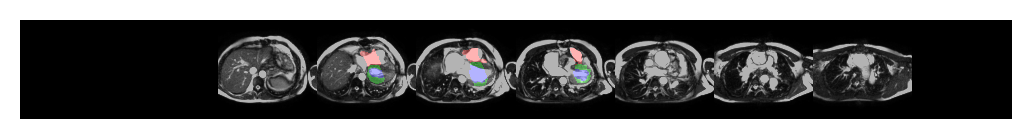

2020-11-27 20:02:50,715 INFO GT on AX


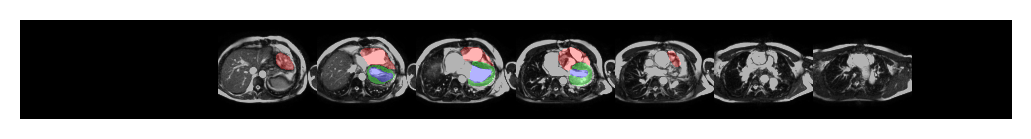

2020-11-27 20:02:51,129 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:02:51,196 INFO DICE LV: 0.7503505349159241
2020-11-27 20:02:51,261 INFO DICE RV: 0.4399101436138153
2020-11-27 20:02:51,328 INFO DICE MYO: 0.562576949596405
2020-11-27 20:02:51,368 INFO m: [[ 0.4773 -0.84   -0.259  -0.9985]
 [ 0.345  -0.0926  0.934  -0.9956]
 [-0.8086 -0.535   0.2456 14.77  ]]
2020-11-27 20:02:51,368 INFO m_mod: [[ 0.4773 -0.84   -0.259  -0.458 ]
 [ 0.345  -0.0926  0.934   0.868 ]
 [-0.8086 -0.535   0.2456  1.222 ]]
2020-11-27 20:02:51,369 INFO m_scaled: [[ 0.4773 -0.84   -0.259  -0.916 ]
 [ 0.345  -0.0926  0.934   1.736 ]
 [-0.8086 -0.535   0.2456  2.443 ]]
2020-11-27 20:02:51,369 INFO 0000-JDRPF7F4_2006-02-28_ES_msk.nrrd
2020-11-27 20:02:51,370 INFO Prediction on AX volume:
2020-11-27 20:02:52,033 INFO AX --> SAX rotated by the model
2020-11-27 20:02:52,034 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:02:52,075 INFO Target (AX2SAX):
2

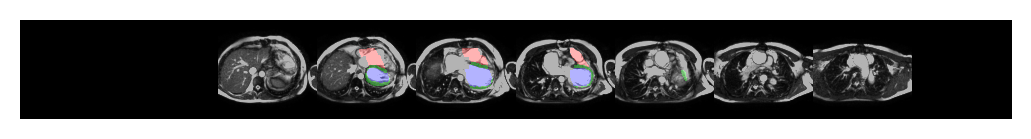

2020-11-27 20:02:57,223 INFO GT on AX


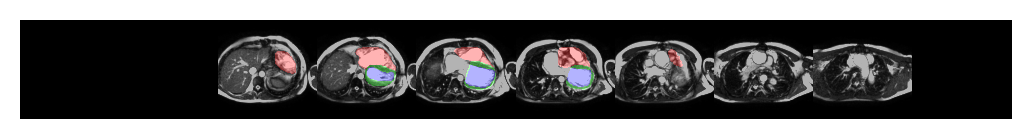

2020-11-27 20:02:57,624 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:02:57,695 INFO DICE LV: 0.8631987571716309
2020-11-27 20:02:57,762 INFO DICE RV: 0.51554274559021
2020-11-27 20:02:57,828 INFO DICE MYO: 0.5876851081848145
2020-11-27 20:02:57,869 INFO m: [[ 0.477  -0.8394 -0.262  -0.9985]
 [ 0.3457 -0.0952  0.934  -0.9956]
 [-0.8086 -0.5356  0.2445 14.8   ]]
2020-11-27 20:02:57,869 INFO m_mod: [[ 0.477  -0.8394 -0.262  -0.4585]
 [ 0.3457 -0.0952  0.934   0.8696]
 [-0.8086 -0.5356  0.2445  1.224 ]]
2020-11-27 20:02:57,870 INFO m_scaled: [[ 0.477  -0.8394 -0.262  -0.917 ]
 [ 0.3457 -0.0952  0.934   1.739 ]
 [-0.8086 -0.5356  0.2445  2.447 ]]
2020-11-27 20:02:57,870 INFO 0000-JP6XAZWH_2007-03-02_ED_msk.nrrd
2020-11-27 20:02:57,871 INFO Prediction on AX volume:
2020-11-27 20:02:58,540 INFO AX --> SAX rotated by the model
2020-11-27 20:02:58,541 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:02:58,563 INFO Target (AX2SAX):
20

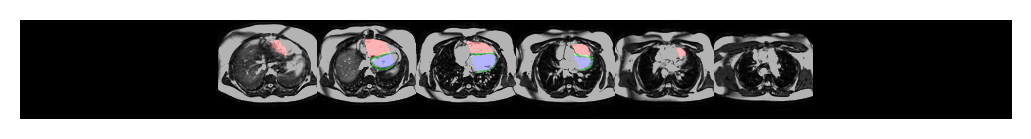

2020-11-27 20:03:03,786 INFO GT on AX


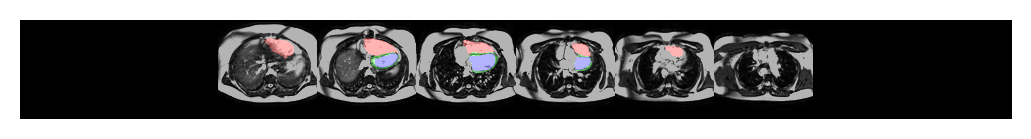

2020-11-27 20:03:04,199 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:03:04,273 INFO DICE LV: 0.8652591109275818
2020-11-27 20:03:04,341 INFO DICE RV: 0.7883255481719971
2020-11-27 20:03:04,410 INFO DICE MYO: 0.6363755464553833
2020-11-27 20:03:04,459 INFO m: [[ 0.4756 -0.8384 -0.2668 -0.999 ]
 [ 0.3457 -0.1013  0.933  -0.9956]
 [-0.809  -0.536   0.2416 14.87  ]]
2020-11-27 20:03:04,459 INFO m_mod: [[ 0.4756 -0.8384 -0.2668 -0.46  ]
 [ 0.3457 -0.1013  0.933   0.874 ]
 [-0.809  -0.536   0.2416  1.2295]]
2020-11-27 20:03:04,460 INFO m_scaled: [[ 0.4756 -0.8384 -0.2668 -0.92  ]
 [ 0.3457 -0.1013  0.933   1.748 ]
 [-0.809  -0.536   0.2416  2.459 ]]
2020-11-27 20:03:04,460 INFO 0000-JP6XAZWH_2007-03-02_ES_msk.nrrd
2020-11-27 20:03:04,460 INFO Prediction on AX volume:
2020-11-27 20:03:05,122 INFO AX --> SAX rotated by the model
2020-11-27 20:03:05,123 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:03:05,170 INFO Target (AX2SAX):


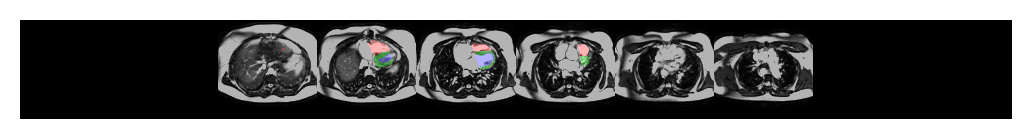

2020-11-27 20:03:10,370 INFO GT on AX


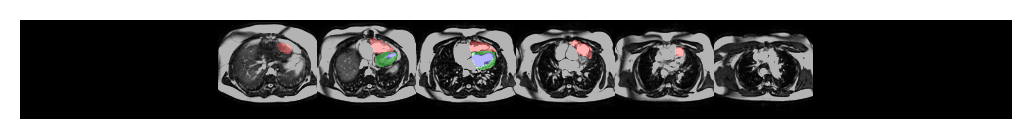

2020-11-27 20:03:10,775 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:03:10,856 INFO DICE LV: 0.7555152773857117
2020-11-27 20:03:10,935 INFO DICE RV: 0.679790735244751
2020-11-27 20:03:11,016 INFO DICE MYO: 0.6960046291351318
2020-11-27 20:03:11,071 INFO m: [[ 0.4766  -0.8394  -0.263   -0.9985 ]
 [ 0.3452  -0.09625  0.934   -0.9956 ]
 [-0.8086  -0.5356   0.2438  14.82   ]]
2020-11-27 20:03:11,072 INFO m_mod: [[ 0.4766  -0.8394  -0.263   -0.4585 ]
 [ 0.3452  -0.09625  0.934    0.871  ]
 [-0.8086  -0.5356   0.2438   1.226  ]]
2020-11-27 20:03:11,072 INFO m_scaled: [[ 0.4766  -0.8394  -0.263   -0.917  ]
 [ 0.3452  -0.09625  0.934    1.742  ]
 [-0.8086  -0.5356   0.2438   2.451  ]]
2020-11-27 20:03:11,073 INFO 0000-K4HCL72E_2007-03-27_ED_msk.nrrd
2020-11-27 20:03:11,073 INFO Prediction on AX volume:
2020-11-27 20:03:11,746 INFO AX --> SAX rotated by the model
2020-11-27 20:03:11,747 INFO AX --> SAX with modified m rotated by the model
2020-11-27 

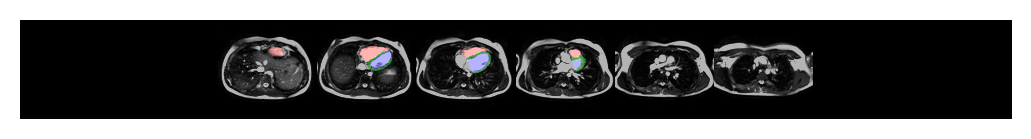

2020-11-27 20:03:17,020 INFO GT on AX


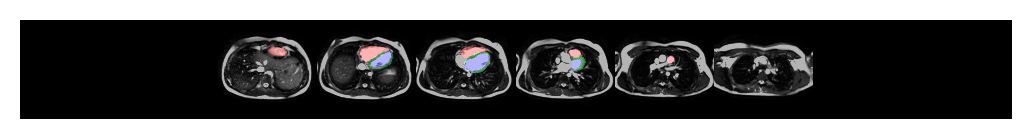

2020-11-27 20:03:17,419 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:03:17,489 INFO DICE LV: 0.9114802479743958
2020-11-27 20:03:17,558 INFO DICE RV: 0.8582245707511902
2020-11-27 20:03:17,628 INFO DICE MYO: 0.6838801503181458
2020-11-27 20:03:17,675 INFO m: [[ 0.4624 -0.8184 -0.342  -0.999 ]
 [ 0.3508 -0.1858  0.918  -0.997 ]
 [-0.8145 -0.5444  0.2013 15.76  ]]
2020-11-27 20:03:17,676 INFO m_mod: [[ 0.4624 -0.8184 -0.342  -0.4795]
 [ 0.3508 -0.1858  0.918   0.9263]
 [-0.8145 -0.5444  0.2013  1.304 ]]
2020-11-27 20:03:17,677 INFO m_scaled: [[ 0.4624 -0.8184 -0.342  -0.959 ]
 [ 0.3508 -0.1858  0.918   1.853 ]
 [-0.8145 -0.5444  0.2013  2.607 ]]
2020-11-27 20:03:17,677 INFO 0000-K4HCL72E_2007-03-27_ES_msk.nrrd
2020-11-27 20:03:17,678 INFO Prediction on AX volume:
2020-11-27 20:03:18,355 INFO AX --> SAX rotated by the model
2020-11-27 20:03:18,356 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:03:18,375 INFO Target (AX2SAX):


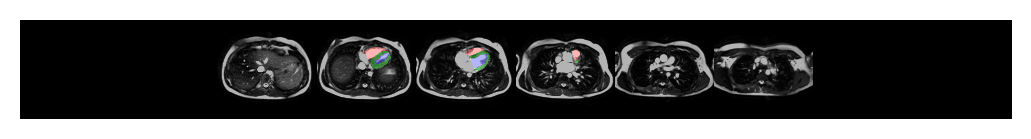

2020-11-27 20:03:23,598 INFO GT on AX


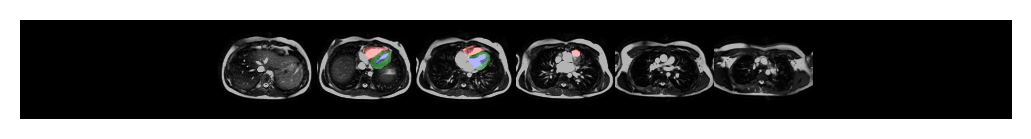

2020-11-27 20:03:24,008 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:03:24,094 INFO DICE LV: 0.8692865967750549
2020-11-27 20:03:24,174 INFO DICE RV: 0.802101731300354
2020-11-27 20:03:24,253 INFO DICE MYO: 0.7468470335006714
2020-11-27 20:03:24,306 INFO m: [[ 0.4636 -0.821  -0.335  -0.999 ]
 [ 0.3503 -0.1777  0.92   -0.9966]
 [-0.814  -0.5435  0.2051 15.67  ]]
2020-11-27 20:03:24,306 INFO m_mod: [[ 0.4636 -0.821  -0.335  -0.4775]
 [ 0.3503 -0.1777  0.92    0.9214]
 [-0.814  -0.5435  0.2051  1.296 ]]
2020-11-27 20:03:24,307 INFO m_scaled: [[ 0.4636 -0.821  -0.335  -0.955 ]
 [ 0.3503 -0.1777  0.92    1.843 ]
 [-0.814  -0.5435  0.2051  2.592 ]]
2020-11-27 20:03:24,308 INFO 0000-K61NJJ2D_2007-05-29_ED_msk.nrrd
2020-11-27 20:03:24,308 INFO Prediction on AX volume:
2020-11-27 20:03:24,989 INFO AX --> SAX rotated by the model
2020-11-27 20:03:24,989 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:03:25,009 INFO Target (AX2SAX):
2

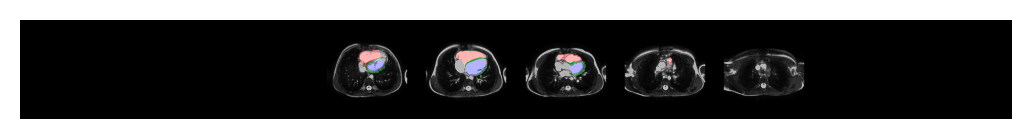

2020-11-27 20:03:30,261 INFO GT on AX


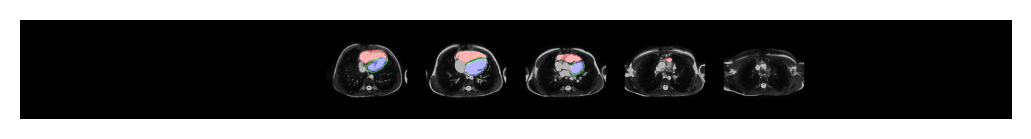

2020-11-27 20:03:30,661 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:03:30,748 INFO DICE LV: 0.9020392298698425
2020-11-27 20:03:30,827 INFO DICE RV: 0.8534774780273438
2020-11-27 20:03:30,908 INFO DICE MYO: 0.5163952112197876
2020-11-27 20:03:30,962 INFO m: [[ 0.4658 -0.8237 -0.3235 -0.999 ]
 [ 0.3499 -0.1644  0.9224 -0.9966]
 [-0.813  -0.5425  0.2114 15.52  ]]
2020-11-27 20:03:30,963 INFO m_mod: [[ 0.4658 -0.8237 -0.3235 -0.4746]
 [ 0.3499 -0.1644  0.9224  0.9126]
 [-0.813  -0.5425  0.2114  1.283 ]]
2020-11-27 20:03:30,963 INFO m_scaled: [[ 0.4658 -0.8237 -0.3235 -0.949 ]
 [ 0.3499 -0.1644  0.9224  1.825 ]
 [-0.813  -0.5425  0.2114  2.566 ]]
2020-11-27 20:03:30,965 INFO 0000-K61NJJ2D_2007-05-29_ES_msk.nrrd
2020-11-27 20:03:30,965 INFO Prediction on AX volume:
2020-11-27 20:03:31,654 INFO AX --> SAX rotated by the model
2020-11-27 20:03:31,657 INFO AX --> SAX with modified m rotated by the model
2020-11-27 20:03:31,702 INFO Target (AX2SAX):


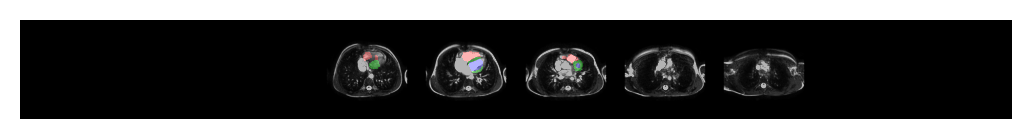

2020-11-27 20:03:36,917 INFO GT on AX


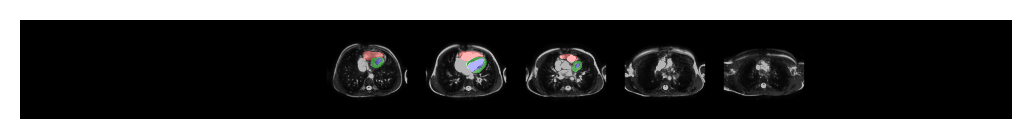

2020-11-27 20:03:37,323 INFO inv mask shape: (144, 224, 224, 4), gt mask shape: (144, 224, 224, 3)
2020-11-27 20:03:37,413 INFO DICE LV: 0.8067169785499573
2020-11-27 20:03:37,493 INFO DICE RV: 0.739387571811676
2020-11-27 20:03:37,573 INFO DICE MYO: 0.6179364919662476
2020-11-27 20:03:37,628 INFO m: [[ 0.4668 -0.8257 -0.3164 -0.999 ]
 [ 0.3494 -0.1565  0.924  -0.9966]
 [-0.8125 -0.5415  0.2153 15.445 ]]
2020-11-27 20:03:37,629 INFO m_mod: [[ 0.4668 -0.8257 -0.3164 -0.4727]
 [ 0.3494 -0.1565  0.924   0.908 ]
 [-0.8125 -0.5415  0.2153  1.277 ]]
2020-11-27 20:03:37,629 INFO m_scaled: [[ 0.4668 -0.8257 -0.3164 -0.9453]
 [ 0.3494 -0.1565  0.924   1.816 ]
 [-0.8125 -0.5415  0.2153  2.555 ]]


In [20]:
# predict on all test images, once with postprocessing, and once without
use_modified_translation = FOCUS_LOSS # True, if we use the unet extension to learn a second set of translation parameters
combine = False
dual_model = False
experiment_identifier = 'tests_downsample_center72_112_112_sp3_1ax_1sax_1focus_thres08_inpl_f0_2ndunet'

logging.info('use modified translation to scale: {}'.format(use_modified_translation))
path_1 = 'data/predicted/{}/3D/'.format(experiment_identifier)
path_2 = path_1.replace('_post', '_NoPost')

# make predictions with different parameters in the same flow
for i in range(ax_full.shape[0]):
    select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=True, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)
    #select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=False, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)

In [ ]:
# Initial version, please check before execute
assert(False==True)
@interact
def select_image_in_batch(im=(0, x_.shape[0] - 1, 1), 
                          slice_n=(1, 6), 
                          export_path='data/predicted/temp/',
                          shift_z=20,
                          debug=False,
                         save=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :return: void
    """
    global m

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    temp = x_[im]
    temp_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(temp[::slice_n])
    plt.show()
    
    # Predict rotation of AX and get transformation matrix
    logging.info('AX --> SAX rotated by the model')
    pred, m, mask_pred= model.predict(np.expand_dims(temp, axis=0))
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    
    # make copy of m for reusage
    #m_ = m.copy()
    m = np.reshape(m, (3,4))
    # scale translation part of the affine matrix from spacing 5 to 1.5
    m_t = m[:,3]
    m_t = (m_t *5)/1.5
    m[:,3] = m_t
    m_ = m.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (SAX):')
    if debug: show_2D_or_3D(temp_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    pred, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_,axis=0)])
    if debug: show_2D_or_3D(pred[0][::slice_n*3])
    plt.show()
    
    # reshape m to matrix
    m = np.reshape(m, (3, 4))

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m
    # calc inverse, flatten the matrix and cut off the last row for the spatial transformer
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]

    # apply the inverse to our AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Apply the invers rotation to our AXtoSAX')
    logging.getLogger().setLevel(logging.ERROR)
    inv, _ = transformer.predict(x=[pred, np.expand_dims(m_matrix_inverse_flatten, axis=0)])
    if debug: show_2D_or_3D(inv[0][::slice_n*3])
    plt.show()

    # load a 3D wrapper model for segmenting the new SAX
    if 'unet' in globals():
        msk = unet.predict(x=pred)
        msk = clean_3d_prediction_3d_cc(from_channel_to_flat(msk[0] >= 0.5))
        msk = transform_to_binary_mask(msk)
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask')
        if debug: show_2D_or_3D(pred[0][::slice_n*3], msk[::slice_n*3])
        plt.show()

        # apply inverse to our msk and plot it together with the inverse AXtoSAX
        logging.getLogger().setLevel(logging.ERROR)
        m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='nearest')
        inv_msk = list()
        for c in range(msk.shape[-1]):
            inv_m, _ = m_transformer.predict(
                x=[np.expand_dims(msk[..., c], axis=0), np.expand_dims(m_matrix_inverse_flatten, axis=0)])
            inv_msk.append(inv_m[..., 0] >= 0.5)
        inv_msk = np.stack(inv_msk, axis=-1)
        
        # postprocessing
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()
        
        inv_msk = from_channel_to_flat(inv_msk[0])
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        
        inv_msk = clean_3d_prediction_3d_cc(inv_msk)
        logging.info('Predicted mask rotated to AX on original AX image - after connected component filtering')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_small) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = clean_3d_prediction_3d_cc(inv_msk)
        logging.info('Predicted mask rotated to AX on original AX image - after connected component filtering')
        if debug: show_2D_or_3D(ax_full_, inv_msk)
        plt.show()

        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on inverse AXtoSAX')
        if debug: show_2D_or_3D(inv[0][::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        logging.info('Predicted mask rotated to AX on original AX image')
        show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # get the AX target segmentation, processed by the generator to have it in the same shape
        #msk_flatten = clean_3d_prediction_3d_cc(from_channel_to_flat(inv_msk[0]))
        msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt)
        logging.info('GT on AX')
        show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3])
        plt.show()
        
        # create a nrrd file for the gt, pred and image volume
        sitk_pred = sitk.GetImageFromArray(inv_msk)
        sitk_ax_img = sitk.GetImageFromArray(ax_full_)
        sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

        ensure_dir(os.path.join(export_path, 'pred'))
        ensure_dir(os.path.join(export_path, 'image'))
        ensure_dir(os.path.join(export_path, 'gt'))
        
        # load a reference nrrd file, copy all metadata and save the volumes
        reference_sitk = sitk.ReadImage(full_file_name)
        if save:
            copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
            copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
            copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
        # shutil.copyfile(full_file_name, os.path.join(export_path, 'gt', filename))
    else:
        logging.info('no unet in global namespace, segmentation is not possible')

    logging.info('MSE: {}'.format(mse(pred[0], ax_full_).numpy().mean()))
    #logging.info('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        print(np.reshape(m[0], (3, 4)))
    except Exception as e:
        pass


# Further tests, where do our model fail, do we over- or under-segment

In [21]:
gt.shape

(144, 224, 224, 3)

In [22]:
zero = np.zeros_like(gt[...,0:1])
temp = np.concatenate((zero,gt),axis=-1)
temp.shape

(144, 224, 224, 4)

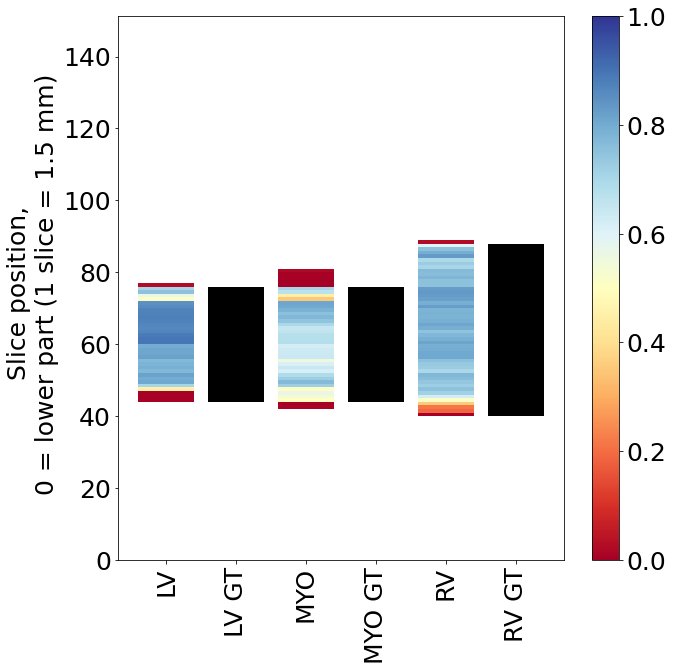

In [23]:
from src.visualization.Visualize import plot_dice_per_slice_bar, plot_dice_per_slice_line
plot_dice_per_slice_bar(gt,pred)

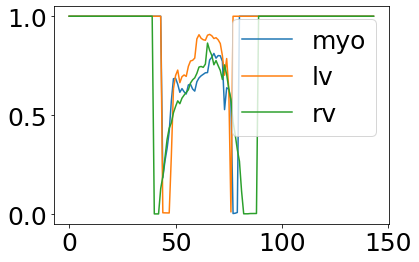

In [31]:
# Create a lineplot for the errors within the volume
plot_dice_per_slice_line(gt,pred)

# Temp tests

In [ ]:
cmap(1)

In [ ]:
# check the memory usage
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
